In [163]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pearson_util 
import descartes
import pygeoj
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import statsmodels.api as sm

In [164]:
gdf_dw = gpd.read_file('C:/Users/seanp/python/NUTS_RG_60M_2016_3035_LEVL_3.geojson')
gdf_dw.iloc[1318:1522]


,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
1318,RO414,3,4,Olt,RO,RO414,RO414,Olt,3,3,"POLYGON ((5500624.645 2481498.725, 5496185.887..."
1319,RO415,3,2,Vâlcea,RO,RO415,RO415,Vâlcea,3,3,"POLYGON ((5457799.893 2527102.235, 5447340.912..."
...,...,...,...,...,...,...,...,...,...,...,...
1520,UKH23,2,4,Hertfordshire,UK,UKH23,UKH23,Hertfordshire,3,1,"POLYGON ((3641428.795 3257056.214, 3631036.624..."
1521,UKH24,3,4,Bedford,UK,UKH24,UKH24,Bedford,3,1,"POLYGON ((3622635.044 3279775.638, 3598326.240..."


<AxesSubplot:>

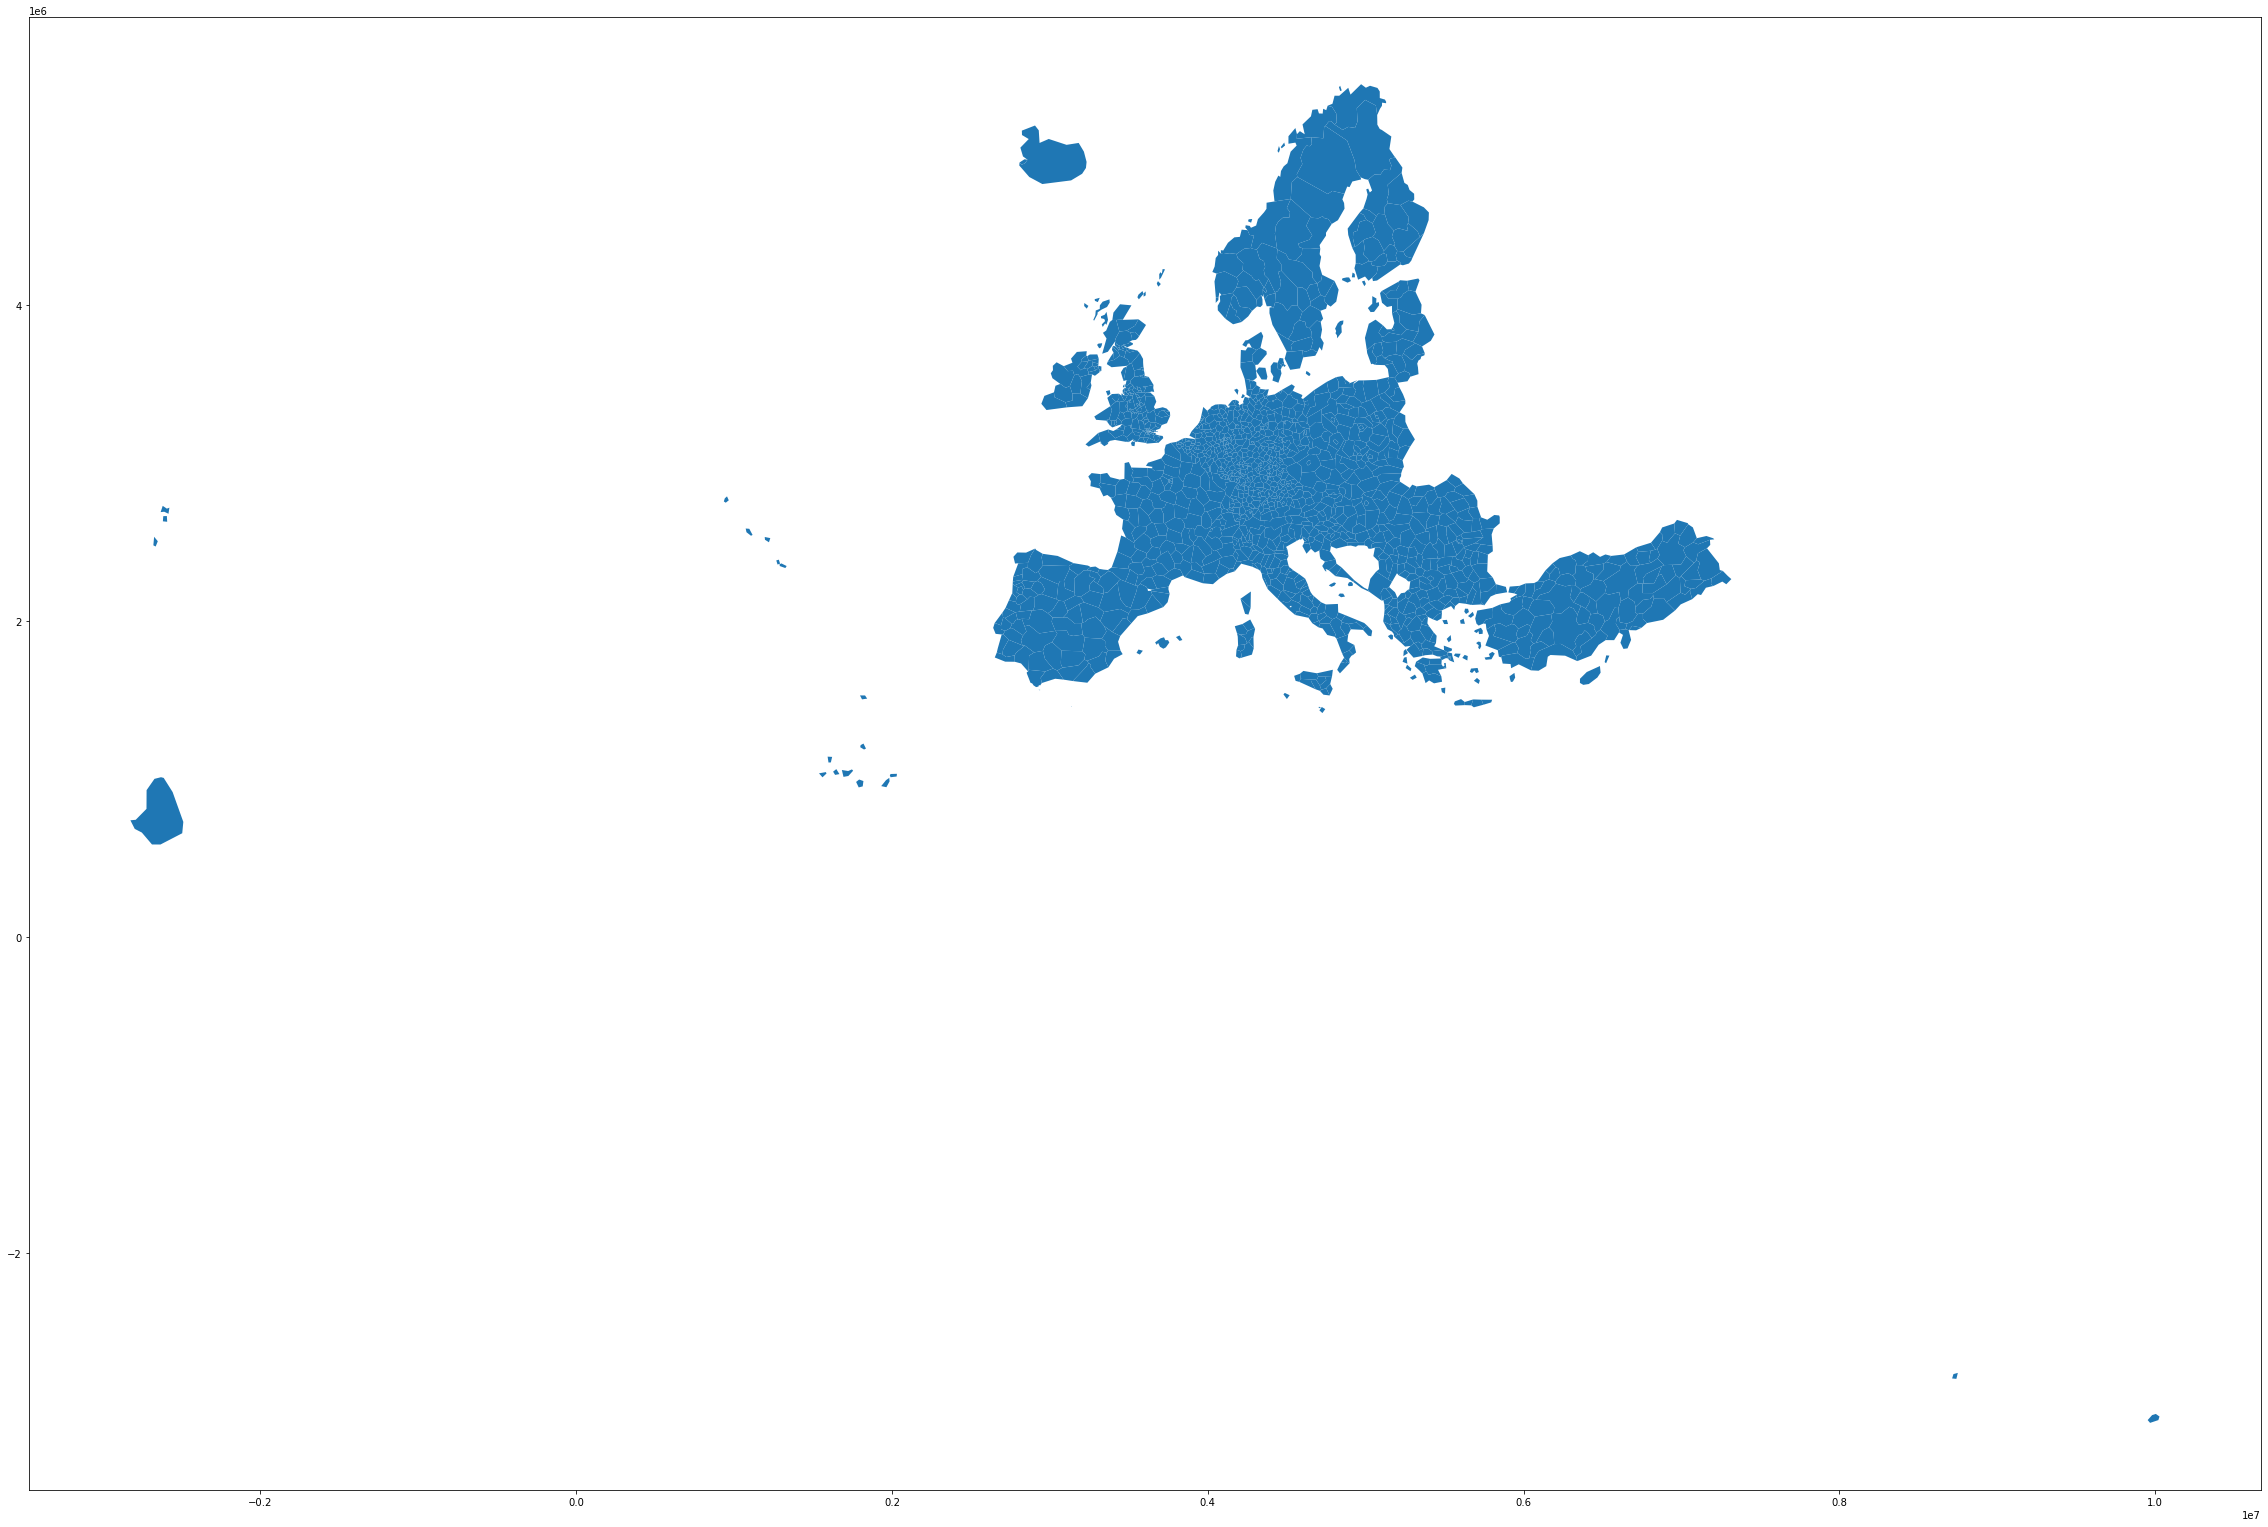

In [165]:
fig, ax = plt.subplots(1, 1, figsize = (40,40))
gdf_dw.plot(ax=ax)

In [166]:
gdf = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_60M_2016_3035_LEVL_3.geojson')

# Creating dataframes of average national annual road freight transport by regions (NUTS 3) and by group of goods (1 000 t)

In [167]:
#National annual road freight transport by regions of unloading (NUTS 3) and by group of goods (1 000 t), from 2008 onwards (road_go_na_ru3g)
df_unloading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_ru3g.tsv.gz',['subsector', 'unit', 'region'])
df_unloading

2019   2018   2017   2016   2015   2014   2013   2012   2011   2010   2009   2008 
subsector unit  region                                                                                    
GT01      THS_T AT111   120.0  221.0  169.0  144.0   85.0  207.0   66.0  119.0   56.0  420.0  372.0   59.0
                AT112   490.0  421.0  383.0  389.0  428.0  322.0  304.0  601.0  437.0  284.0  404.0  473.0
...                       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
UNK       THS_T UKJ33     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   35.0    NaN    NaN    NaN
                UKK12     NaN    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

[36696 rows x 12 columns]

In [168]:
df_unloading_total = df_unloading.loc['TOTAL']

In [169]:
df_unloading_total = df_unloading_total.droplevel(0)
df_unloading_total

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
region,,,,,,,,,,,,
AT111,1453.0,1419.0,1192.0,1528.0,1438.0,1161.0,1252.0,1586.0,1117.0,1457.0,1724.0,929.0
AT112,7576.0,7076.0,6407.0,7187.0,6817.0,7287.0,6168.0,7869.0,6993.0,5222.0,5713.0,6397.0
...,...,...,...,...,...,...,...,...,...,...,...,...
UKN15,5344.0,3111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,4438.0,4593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
#sets index of the df to the same index the gdf has and thereby delets all rowes which have a different id (old NUTS 3 data)
df_unloading_nuts3 = df_unloading_total.reindex(gdf.set_index('id').index)
df_unloading_nuts3

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,,,,,,,,,,,,
CZ052,29969.0,24903.0,22386.0,23670.0,21968.0,16606.0,15799.0,14299.0,17991.0,13200.0,17589.0,18524.0
CZ053,27400.0,16323.0,19488.0,19740.0,18901.0,16187.0,14604.0,12494.0,14595.0,12911.0,16147.0,18915.0
...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,21979.0,24404.0,19840.0,27399.0,22622.0,21253.0,21809.0,21594.0,23160.0,25347.0,22960.0,20277.0
UKH24,6064.0,3495.0,4272.0,3578.0,4575.0,4697.0,3487.0,5499.0,NaN,NaN,NaN,NaN


In [171]:
#filters the countries that have no data
no_data_nuts3 = df_unloading_nuts3[df_unloading_nuts3.isna().all(axis=1)].sort_index().index

In [172]:
#National annual road freight transport by regions of loading (NUTS 3) and by group of goods (1 000 t), from 2008 onwards (road_go_na_rl3g
df_loading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_rl3g.tsv.gz',['subsector', 'unit', 'region'])

In [173]:
df_loading_total = df_loading.loc['TOTAL']

In [174]:
df_loading_total = df_loading_total.droplevel(0)

In [175]:
#sets index of the df to the same index the gdf has and thereby delets all rowes which have a different id (old NUTS 3 data)
df_loading_nuts3 = df_loading_total.reindex(gdf.set_index('id').index)

In [176]:
no_data_nuts3 = df_unloading_nuts3[df_unloading_nuts3.isna().all(axis=1)].sort_index().index

In [177]:
df_loading_nuts3.head()

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,,,,,,,,,,,,
CZ052,31164.0,23410.0,22302.0,22533.0,20556.0,16265.0,15133.0,14044.0,17536.0,12320.0,16522.0,17859.0
CZ053,27127.0,20301.0,20399.0,21064.0,19896.0,16948.0,15222.0,12602.0,14166.0,14423.0,16343.0,20090.0
CZ063,22196.0,26155.0,18682.0,20785.0,19078.0,15516.0,12487.0,9854.0,13296.0,14551.0,18543.0,20061.0
CZ064,49041.0,47453.0,43448.0,38848.0,40457.0,35683.0,29350.0,25806.0,26051.0,27880.0,31335.0,40006.0
CZ071,37656.0,34631.0,29204.0,26120.0,25596.0,26760.0,18776.0,23872.0,21159.0,19474.0,25554.0,25133.0


In [178]:
#Concatinates df --> takes 2 df and joins them together
df_average_transport_total = pd.concat((df_unloading_nuts3, df_loading_nuts3))

In [179]:
#takes lines with same index and calculates mean of them
df_average_transport_total = df_average_transport_total.groupby(df_average_transport_total.index).mean()

In [180]:
#sets the index 'country' and takes it from the cntr_code column of the gdf
df_average_transport_total = df_average_transport_total.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)

In [181]:
df_average_transport_total.tail()

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKN12,UK,3002.0,3325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,5311.5,3286.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,4799.5,2361.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN15,UK,4986.5,3731.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,4350.5,4223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Compacted

In [182]:
#unloading
df_unloading_GT01 = df_unloading.loc['GT01']
df_unloading_GT01 = df_unloading_GT01.droplevel(0)
df_unloading_GT01_nuts3 = df_unloading_GT01.reindex(gdf.set_index('id').index)
#loading
df_loading_GT01 = df_loading.loc['GT01']
df_loading_GT01 = df_loading_GT01.droplevel(0)
df_loading_GT01_nuts3 = df_loading_GT01.reindex(gdf.set_index('id').index)
#combining
df_average_transport_GT01 = pd.concat((df_unloading_GT01_nuts3, df_loading_GT01_nuts3))
df_average_transport_GT01 = df_average_transport_GT01.groupby(df_average_transport_GT01.index).mean()
df_average_transport_GT01 = df_average_transport_GT01.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)
#share
df_transport_share_GT01 = df_average_transport_GT01.div(df_average_transport_total)
df_transport_share_GT01.tail()

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKN12,UK,0.147568,0.065865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,0.040102,0.067701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,0.030420,0.016727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN15,UK,0.150607,0.081211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,0.092058,0.085958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
#unloading
df_unloading_GT02 = df_unloading.loc['GT02']
df_unloading_GT02 = df_unloading_GT02.droplevel(0)
df_unloading_GT02_nuts3 = df_unloading_GT02.reindex(gdf.set_index('id').index)
#loading
df_loading_GT02 = df_loading.loc['GT02']
df_loading_GT02 = df_loading_GT02.droplevel(0)
df_loading_GT02_nuts3 = df_loading_GT02.reindex(gdf.set_index('id').index)
#combining
df_average_transport_GT02 = pd.concat((df_unloading_GT02_nuts3, df_loading_GT02_nuts3))
df_average_transport_GT02 = df_average_transport_GT02.groupby(df_average_transport_GT02.index).mean()
df_average_transport_GT02 = df_average_transport_GT02.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)
#share
df_transport_share_GT02 = df_average_transport_GT02.div(df_average_transport_total)
df_transport_share_GT02.tail()

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKN12,UK,0.013824,0.006316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,NaN,0.010650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN15,UK,0.002607,0.006433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,0.030341,0.002842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Multiply shares of transported good types with transportdistance and amount of these good types = amount of specific good types transported for specific distance in each NUTS 3 region

In [184]:
df_transportdistance = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_dctg.tsv.gz',['Type_of_carriage', 'Distance','Subsector', 'Unit', 'Country'])

In [185]:
df_transportdistance

2019       2018       2017       2016       2015       2014       2013       2012       2011       2010       2009       2008 
Type_of_carriage Distance  Subsector Unit  Country                                                                                                                                    
HIRE             KM150-499 GT01      THS_T AT          1904.0     2007.0     2275.0     2138.0     2131.0     1759.0     1689.0     2037.0     1836.0     1519.0     1263.0     1111.0
                                           BE          4249.0     3975.0     3238.0     3754.0     4607.0     2015.0     1766.0     2039.0     1626.0     1515.0     1781.0     1503.0
...                                                       ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...
TOT              TOTAL     TOTAL     THS_T UK       1453669.0  1408269.0  1402948.0  1435273.0  1450651.0  1329869.0  1328683.0  1445128.0  1466360.0  1500205.0  1442918.0  1755350.0
                           UNK       THS_T UK             NaN        NaN        NaN        1.0        NaN        NaN        NaN        NaN       35.0        NaN        NaN        NaN

[8809 rows x 12 columns]

In [186]:
#distance is not selected yet. 'TOT' is all distance classes
df_transportdistance = df_transportdistance.loc[('TOT', 'TOTAL', 'GT01')]
df_transportdistance = df_transportdistance.droplevel(0)
df_transportdistance

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
Country,,,,,,,,,,,,
AT,20123.0,20403.0,21207.0,20101.0,18420.0,17585.0,16393.0,17401.0,16792.0,16982.0,16158.0,16370.0
BE,15288.0,14830.0,17183.0,15166.0,22226.0,15810.0,13565.0,15258.0,12517.0,12269.0,12766.0,12279.0
...,...,...,...,...,...,...,...,...,...,...,...,...
SK,26705.0,15341.0,11188.0,14556.0,13967.0,13315.0,10357.0,13626.0,11948.0,14448.0,13013.0,15860.0
UK,91782.0,112143.0,97277.0,93802.0,97678.0,104848.0,98567.0,112051.0,104438.0,110355.0,105405.0,110410.0


In [187]:
#mulitply transport_share_goodstype with transportamount and can be selected by distance
df_transportdistance_share_GT01 = df_transport_share_GT01.multiply(df_transportdistance, level = 'country')
df_transportdistance_share_GT01

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
AL011,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL012,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN15,UK,13822.978442,9107.298043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,8449.302609,9639.571158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Adding column to gdf

In [188]:
df_transportdistance_share_GT01.columns = ['2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008']

In [189]:
#droping country index
df_tds_GT01 = df_transportdistance_share_GT01.droplevel(1)

In [190]:
#set the id column as an index so pandas will align the id of the gdf with the id of the df
gdf_dw = gdf_dw.set_index('id')

In [191]:
#add the data from the df to the gdf
gdf1 = gdf_dw.join(df_tds_GT01)
gdf_select = gdf1.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000'])
gdf_select

,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,,,,,,,,,,,,,,,,,,,,,,
CZ052,3,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",1796.058037,2552.959038,3263.339621,3095.369998,3783.604882,2235.072556,2719.841265,3213.315528,2091.392800,2254.284522,1752.981267,1704.001072
CZ053,3,4,Pardubický kraj,CZ,CZ053,CZ053,Pardubický kraj,3,3,"POLYGON ((4812156.935 2965655.696, 4782782.205...",1120.938691,1486.482361,2031.615012,1408.292667,3257.964843,2331.778180,1831.497854,2074.445967,1965.831821,2192.207361,1155.973284,2211.510704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,2,4,Hertfordshire,UK,UKH23,UKH23,Hertfordshire,3,1,"POLYGON ((3641428.795 3257056.214, 3631036.624...",2404.183755,6573.859023,2919.822051,2508.287011,4274.028138,6456.963322,8357.203098,5337.623520,7021.968200,3564.388289,4574.650836,1982.751738
UKH24,3,4,Bedford,UK,UKH24,UKH24,Bedford,3,1,"POLYGON ((3622635.044 3279775.638, 3598326.240...",1926.391080,10711.621516,7769.423241,10207.248884,6261.738595,7639.317474,7387.012304,4109.707524,NaN,NaN,NaN,NaN


# Mapping new gdf

<AxesSubplot:>

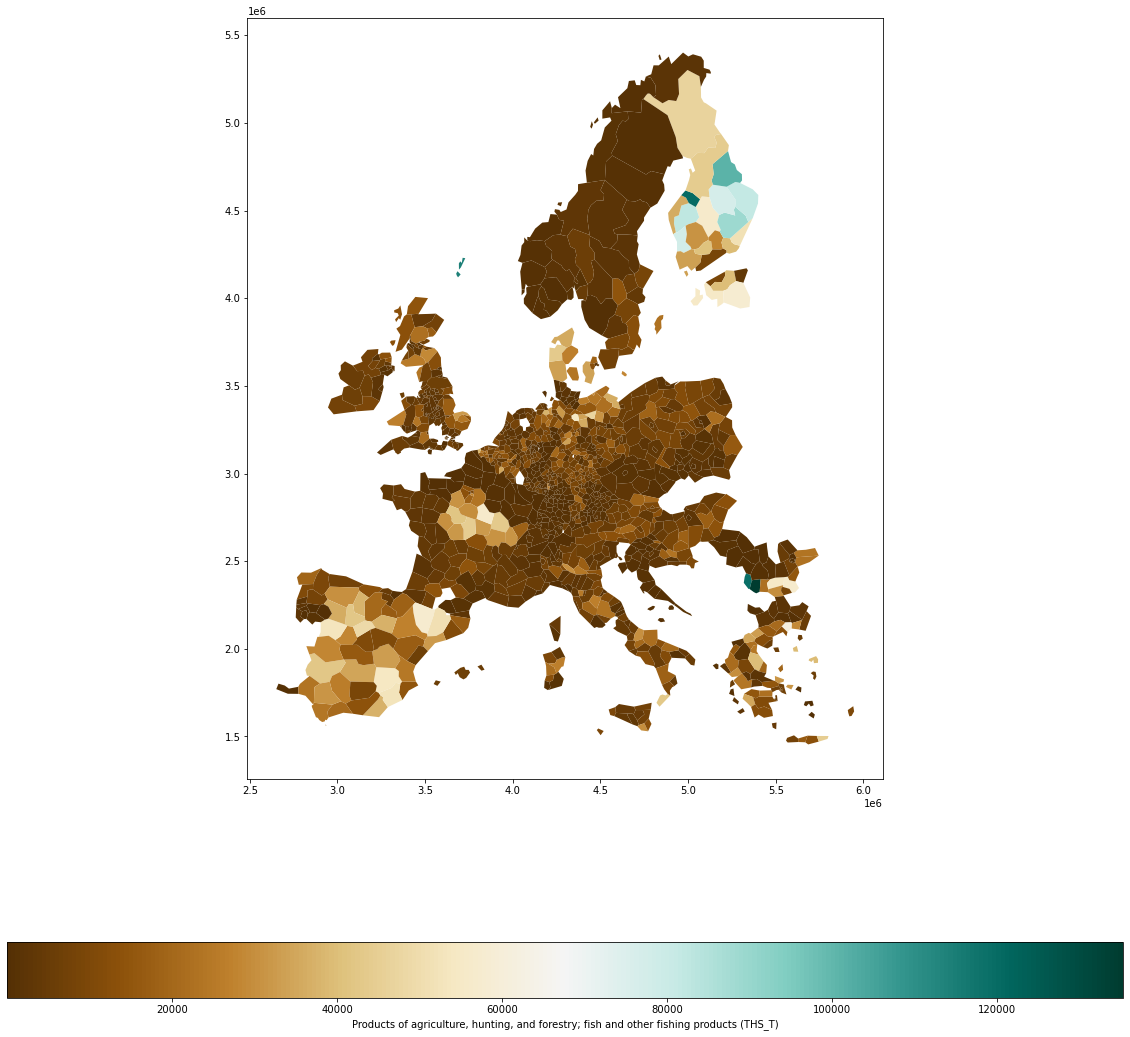

In [192]:
fig, ax = plt.subplots(1, 1, figsize = (20,20))
gdf_select.plot(column = '2019', 
          ax = ax, 
          legend=True,
         legend_kwds = {'label': 'Products of agriculture, hunting, and forestry; fish and other fishing products (THS_T)',
                        'orientation': "horizontal"},
         cmap = 'BrBG',
         
         )
        

# Calculating Energy consumption of Transport fleet

Calculating the share that each region has compared to its national transport 

In [193]:
#load national transport amount with NUTS 3 regions, take average of un- loading, sum up total transport
df_average_transport_total_EC = df_unloading_nuts3.add(df_loading_nuts3).div(2)
df_average_transport_total_EC = df_average_transport_total_EC.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)
sum_total_national_transport = df_average_transport_total_EC.groupby('country').sum()

In [194]:
df_average_transport_total_EC.iloc[1320:1522]

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKH25,UK,6905.5,6347.0,6146.0,7611.0,8662.5,6463.0,5062.0,9614.0,NaN,NaN,NaN,NaN
UKH31,UK,1801.0,721.0,435.5,1118.5,530.5,1480.5,1016.5,732.0,713.5,1004.0,826.5,1082.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,21588.5,23592.5,18657.0,26009.5,20328.5,19071.5,18688.0,21496.5,21320.5,25821.0,22983.5,19991.0
UKH24,UK,6098.5,3067.5,4582.5,3584.0,3814.0,4014.5,2682.0,4785.0,NaN,NaN,NaN,NaN


In [195]:
#test if the tables are summed up correctly
test = df_average_transport_total_EC.xs('UK', level='country')
test.sum()

2019     1453669.5
2018     1408268.5
           ...    
2009      833711.0
2008      987731.5
Length: 12, dtype: float64

In [196]:
sum_total_national_transport

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
country,,,,,,,,,,,,
AL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT,377402.0,367527.5,360241.0,350227.0,325651.0,323233.5,300228.5,305378.5,313114.5,299971.5,303059.0,332079.0
...,...,...,...,...,...,...,...,...,...,...,...,...
TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK,1453669.5,1408268.5,1260223.5,1288953.0,1307366.5,913905.5,924387.0,995509.0,838530.0,873381.0,833711.0,987731.5


In [197]:
#calculates the share that each region has of the total goods transported in the country and tests if it has been calculated correctly (assert if sum of all shares = 1 rounded to two decimals)
share_total_national_transport_region = df_average_transport_total_EC.divide(sum_total_national_transport, level = 'country')
test = share_total_national_transport_region.sum(level='country', min_count=1)
test.columns = test.columns.astype(int) #  test.columns.str.strip()
assert (test[2019].dropna().round(2) == 1.00).all()

In [198]:
share_total_national_transport_region

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
CZ052,CZ,0.064279,0.054079,0.053354,0.060268,0.056646,0.050714,0.053494,0.050371,0.061567,0.042337,0.052482,0.047574
CZ053,CZ,0.057333,0.040995,0.047622,0.053226,0.051681,0.051122,0.051582,0.044601,0.049842,0.045347,0.049988,0.051003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,0.014851,0.016753,0.014805,0.020179,0.015549,0.020868,0.020217,0.021593,0.025426,0.029564,0.027568,0.020239
UKH24,UK,0.004195,0.002178,0.003636,0.002781,0.002917,0.004393,0.002901,0.004807,NaN,NaN,NaN,NaN


In [199]:
share_total_national_transport_region_filledna = share_total_national_transport_region.interpolate(method ='linear', axis = 1, limit_direction ='backward')
share_total_national_transport_region_filledna

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
CZ052,CZ,0.064279,0.054079,0.053354,0.060268,0.056646,0.050714,0.053494,0.050371,0.061567,0.042337,0.052482,0.047574
CZ053,CZ,0.057333,0.040995,0.047622,0.053226,0.051681,0.051122,0.051582,0.044601,0.049842,0.045347,0.049988,0.051003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,0.014851,0.016753,0.014805,0.020179,0.015549,0.020868,0.020217,0.021593,0.025426,0.029564,0.027568,0.020239
UKH24,UK,0.004195,0.002178,0.003636,0.002781,0.002917,0.004393,0.002901,0.004807,NaN,NaN,NaN,NaN


1. Try to calculate enrgy consumption of transport fleet
international transport (country, (THS_t)) + national transport (country, (THS_t)) = total transport (THS_t)
Mio_Tkm of total transport (country) / total transport (THS_t) = km driven total transport (Country, (THS_km))
km driven total transport (Country, (THS_km)) * share of transport of each region (region) = km driven each region (THS_km)
km driven each region (THS_km) * energy consumption per km = Energy consumtion of transport (MWh)

In [200]:
#loading international transport dataset
df_unloading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_ugtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
df_loading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_lgtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
#filtering dataset to proper data
df_unloading_int_EC = df_unloading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_unloading_int_EC = df_unloading_int_EC.droplevel(0)
df_loading_int_EC = df_loading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_loading_int_EC = df_loading_int_EC.droplevel(0)
#average of loaning and unloading
df_average_transport_total_int_EC = pd.concat((df_loading_int_EC, df_unloading_int_EC))
df_average_transport_total_int_EC = df_average_transport_total_int_EC.groupby(df_average_transport_total_int_EC.index).mean()
df_average_transport_total_int_EC

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
country,,,,,,,,,,,,
AT,9917.5,10505.0,10841.5,10602.5,10228.0,10478.5,10034.0,11545.5,13000.5,12434.5,13583.0,15152.5
BE,21691.0,21912.0,25084.5,23268.0,24790.0,20476.0,21856.0,22092.5,23466.5,24614.5,26847.0,28289.5
...,...,...,...,...,...,...,...,...,...,...,...,...
SK,13051.5,13487.0,11855.0,12069.5,11218.0,9999.5,9481.0,10059.0,10177.0,9395.0,8822.5,9388.0
UK,7299.0,7109.0,6013.5,6270.5,7401.0,8493.0,8525.5,8666.5,8818.0,9314.5,8281.0,9172.5


In [201]:
#loading and filtering MIO_Tkm dataset 
df_total_transport_mio_Tkm_country_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_tott.tsv.gz',[ 'Type_of_carriage', 'Type_of operation', 'unit', 'country'])
df_total_transport_mio_Tkm_country_EC = df_total_transport_mio_Tkm_country_EC.loc[('TOT', 'TOTAL', 'MIO_TKM')]
df_total_transport_mio_Tkm_country_EC = df_total_transport_mio_Tkm_country_EC.drop(['EU15', 'EU25', 'EU27_2007', 'EU27_2020', 'EU28', 'LI'])
df_total_transport_mio_Tkm_country_EC

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999
country,,,,,,,,,,,,,,,,,,,,,
AT,26444.0,25763.0,25978.0,26138.0,25458.0,25260.0,24213.0,26089.0,28542.0,28659.0,29075.0,34313.0,37402.0,39187.0,37044.0,39186.0,39557.0,38498.0,37532.0,35122.0,33981.0
BE,34829.0,32685.0,34220.0,35192.0,36078.0,31808.0,32796.0,32105.0,33107.0,35002.0,36174.0,38356.0,42085.0,43017.0,43847.0,47878.0,50542.0,52889.0,53182.0,51047.0,37284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK,33941.0,35586.0,35411.0,36139.0,33540.0,31358.0,NaN,NaN,NaN,27575.0,27705.0,29276.0,NaN,NaN,22566.0,NaN,NaN,NaN,NaN,NaN,NaN
UK,160831.0,159282.0,NaN,155042.0,NaN,135393.0,139703.0,150949.0,NaN,NaN,139536.0,160296.0,170991.0,NaN,161285.0,162654.0,167143.0,164035.0,NaN,165621.0,166260.0


In [202]:
#sum of int + national transport on country level, devide mio Tkm per country by the THS_t transport per country and multipy that with the share of transport per region
total_national_international_transport_country_test = pd.concat((df_average_transport_total_int_EC, sum_total_national_transport))
total_national_international_transport_country_test = total_national_international_transport_country_test.groupby('country').sum()
km_driven_country = df_total_transport_mio_Tkm_country_EC.divide(total_national_international_transport_country_test)
km_driven_region_test = share_total_national_transport_region.multiply(km_driven_country)
km_driven_region_test.sum(level = 'country') 

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
country,,,,,,,,,,,,,,,,,,,,,
CZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126818,0.131547,0.161320,0.176873,0.169822,0.176127,0.155813,0.146739,0.124621,0.000000,0.000000,0.000000
DE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130297,0.130275,0.134122,0.126673,0.111905,0.109448,0.106830,0.106789,0.104395,0.101804,0.101174,0.099229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160794,0.165721,0.000000,0.000000,0.150321,0.149749,0.146784,0.000000,0.119703,0.000000,0.112537,0.110085


In [203]:
total_national_international_transport_country_test

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
country,,,,,,,,,,,,
AL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT,387319.5,378032.5,371082.5,360829.5,335879.0,333712.0,310262.5,316924.0,326115.0,312406.0,316642.0,347231.5
...,...,...,...,...,...,...,...,...,...,...,...,...
TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK,1460968.5,1415377.5,1266237.0,1295223.5,1314767.5,922398.5,932912.5,1004175.5,847348.0,882695.5,841992.0,996904.0


In [204]:
km_driven_region_test

,,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
id,country,,,,,,,,,,,,,,,,,,,,,
CZ052,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006033,0.006904,0.006830,0.010890,0.008554,0.009422,0.007902,0.008312,0.007511,NaN,NaN,NaN
CZ053,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006468,0.006576,0.007315,0.008816,0.007574,0.009085,0.007965,0.007584,0.006633,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003254,0.004569,NaN,NaN,0.003246,0.003027,0.003063,NaN,0.002415,NaN,0.001885,0.001635
UKH24,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000723,0.000434,0.000645,NaN,0.000333,NaN,0.000245,0.000462


2. Try to calculate energy consumption of vehicle fleet
Million vehicle-kilometers * energy consumption per kilometer * share of each region = energyconsumtion of fleet

In [205]:
df_total_transport_mio_Vkm_country_2 = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_tott.tsv.gz',[ 'Type_of_carriage', 'Type_of operation', 'unit', 'country'])
df_total_transport_mio_Vkm_country_2 = df_total_transport_mio_Vkm_country_2.loc[('TOT', 'TOTAL', 'MIO_VKM')]
df_total_transport_mio_Vkm_country_2 = df_total_transport_mio_Vkm_country_2.drop(['EU15', 'EU25', 'EU27_2007', 'EU27_2020', 'EU28', 'LI'])
df_total_transport_mio_Vkm_country_2.columns = df_total_transport_mio_Vkm_country_2.columns.astype(int)
df_total_transport_mio_Vkm_country_2

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999
country,,,,,,,,,,,,,,,,,,,,,
AT,2713.0,2678.0,2671.0,2643.0,2573.0,2500.0,2411.0,2512.0,2690.0,2709.0,2778.0,3154.0,3327.0,3391.0,3137.0,3268.0,3328.0,3235.0,3218.0,3087.0,3057.0
BE,2807.0,2554.0,2774.0,2728.0,2850.0,2373.0,2378.0,2326.0,2392.0,2478.0,2584.0,2678.0,3173.0,3419.0,3355.0,3755.0,3869.0,4208.0,4316.0,4034.0,3103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK,4167.0,3974.0,4317.0,4020.0,3700.0,3648.0,NaN,NaN,NaN,3420.0,3438.0,3576.0,NaN,NaN,3158.0,NaN,NaN,NaN,NaN,NaN,NaN
UK,19829.0,19429.0,NaN,19982.0,NaN,17789.0,18134.0,19550.0,NaN,NaN,18854.0,21212.0,22579.0,NaN,22271.0,22448.0,24221.0,24145.0,NaN,25037.0,25294.0


In [206]:
df_total_transport_mio_Vkm_country_2_filledna = df_total_transport_mio_Vkm_country_2.interpolate(method ='linear', axis = 1)
df_total_transport_mio_Vkm_country_2_filledna

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999
country,,,,,,,,,,,,,,,,,,,,,
AT,2713.0,2678.0,2671.0,2643.0,2573.0,2500.0,2411.0,2512.0,2690.0,2709.0,2778.0,3154.0,3327.000000,3391.000000,3137.0,3268.0,3328.0,3235.0,3218.0,3087.0,3057.0
BE,2807.0,2554.0,2774.0,2728.0,2850.0,2373.0,2378.0,2326.0,2392.0,2478.0,2584.0,2678.0,3173.000000,3419.000000,3355.0,3755.0,3869.0,4208.0,4316.0,4034.0,3103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK,4167.0,3974.0,4317.0,4020.0,3700.0,3648.0,3591.0,3534.0,3477.0,3420.0,3438.0,3576.0,3436.666667,3297.333333,3158.0,3158.0,3158.0,3158.0,3158.0,3158.0,3158.0
UK,19829.0,19429.0,19705.5,19982.0,18885.5,17789.0,18134.0,19550.0,19318.0,19086.0,18854.0,21212.0,22579.000000,22425.000000,22271.0,22448.0,24221.0,24145.0,24591.0,25037.0,25294.0


In [207]:
toe = pd.read_excel('C:/Users/seanp/python/anaconda3/envs/python_backup/my_python_work/Data/Fuel_Consumption.xlsx', sheet_name = 'Summary_Fuel_Efficiency')
toe = toe.set_index('country')
toe = toe.drop(columns=['Type'])
toe.columns = toe.columns.astype(int)
toe

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
UK,41.42,41.86,41.83,41.56,42.20,43.01,42.03,44.34,44.12,46.24,47.23,44.03,45.11,45.01,46.17,44.46,42.784251,40.987927,39.080214,37.069830,34.965049,32.773716,30.503275,28.160781,27.116831,26.006465,24.946746,23.935322,22.969949,22.048488,21.168900,20.501129,20.487482,20.004620,19.630404,19.358502,19.182884,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807
SK,41.41,37.35,45.39,31.05,32.32,42.31,46.30,46.35,45.29,41.70,48.26,46.26,45.53,47.13,44.15,42.68,40.715086,38.858005,37.109629,35.468110,33.929696,32.489361,31.141290,29.879248,28.696858,27.481500,26.361038,25.324215,24.361088,23.328992,22.376747,21.636518,21.029816,20.536235,20.138443,19.821712,19.573528,19.519160,19.362214,19.248213,19.170412,19.123067,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT,13.53,12.68,4.79,9.61,13.49,7.91,8.05,8.73,19.14,13.93,15.00,13.60,13.14,12.88,12.31,12.10,13.664993,15.153992,16.569064,17.912208,19.185358,20.390388,21.529111,22.603279,23.614589,24.493914,25.315503,26.080831,25.093144,24.135913,23.208170,22.422499,21.716858,21.089307,20.537972,20.061039,20.065586,19.734189,19.472120,19.277796,19.157369,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807
NL,44.51,45.63,45.45,45.50,45.37,46.44,50.47,52.05,53.02,48.71,55.06,56.73,53.64,50.50,41.62,42.40,41.257663,39.984136,38.582964,37.057569,35.411259,33.647225,31.768547,29.778201,27.679059,26.596768,25.550523,24.539109,23.561352,22.616119,21.702314,20.972666,20.343821,20.346947,19.922269,19.587592,19.340296,19.177849,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807,19.097807


In [208]:
toe_mio_Vkm_country = toe.multiply(df_total_transport_mio_Vkm_country_2_filledna)
toe_mio_Vkm_country.columns = toe_mio_Vkm_country.columns.astype(str)
print(toe_mio_Vkm_country.columns)

Index(['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050'], dtype='object')


In [209]:
share_total_national_transport_region_filledna.columns = share_total_national_transport_region_filledna.columns.str.replace(' ', '')
print(share_total_national_transport_region_filledna.columns)

Index(['2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008'], dtype='object')


In [210]:
MWh_region = toe_mio_Vkm_country.multiply(share_total_national_transport_region_filledna)
MWh_region

,,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13297.816779,14000.464773,11164.061385,17035.058744,13674.817486,14456.516569,13640.830311,15115.566199,14603.996140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CZ053,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14256.145548,13335.144102,11957.619667,13790.787979,12108.217889,13939.611508,13750.385214,13790.768080,12897.462470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18941.428859,24033.773372,26650.304954,21626.668716,19043.297548,16501.051531,17139.374603,13055.873319,17251.140289,11957.424447,12720.256668,10916.368751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKH24,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4238.930931,2368.141064,3607.792745,2449.521649,2377.134770,2936.961866,1653.889470,3083.747126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
MWh_region_filledna = MWh_region.interpolate(method ='linear', axis = 1)
MWh_region_filledna

,,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13297.816779,14000.464773,11164.061385,17035.058744,13674.817486,14456.516569,13640.830311,15115.566199,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140,14603.996140
CZ053,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14256.145548,13335.144102,11957.619667,13790.787979,12108.217889,13939.611508,13750.385214,13790.768080,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470,12897.462470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18941.428859,24033.773372,26650.304954,21626.668716,19043.297548,16501.051531,17139.374603,13055.873319,17251.140289,11957.424447,12720.256668,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751,10916.368751
UKH24,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4238.930931,2368.141064,3607.792745,2449.521649,2377.134770,2936.961866,1653.889470,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126,3083.747126


<AxesSubplot:>

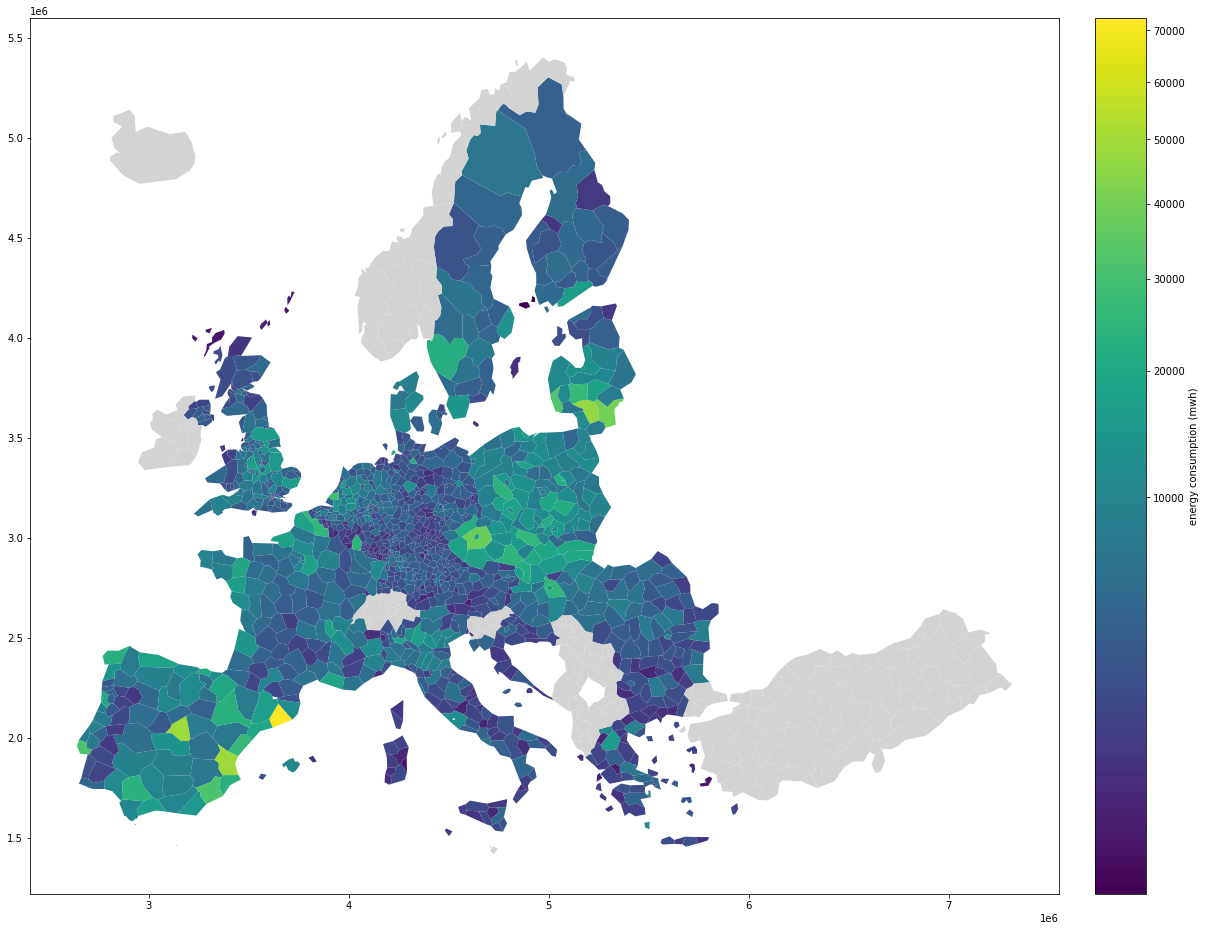

In [212]:
gdf_MWh_region = gdf_dw.join(MWh_region_filledna)
gdf_MWh_region = gdf_MWh_region.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200'])

fig, ax = plt.subplots(1, 1, figsize = (20,20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
gdf_MWh_region = gdf_MWh_region.cx[0.22:,1:]

gdf_MWh_region.plot(column = '2050', 
         ax = ax, 
         legend=True,
         cax = cax,
         legend_kwds = {'label': 'energy consumption (mwh)'},
         cmap = 'viridis',
         norm=mcolors.PowerNorm(0.4),
         missing_kwds= dict(color = "lightgrey")
         )

<AxesSubplot:>

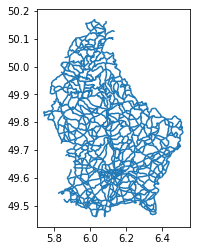

In [213]:
roads=gpd.read_file('C:/Users/seanp/Desktop/RoadL')
roads.plot()

<AxesSubplot:>

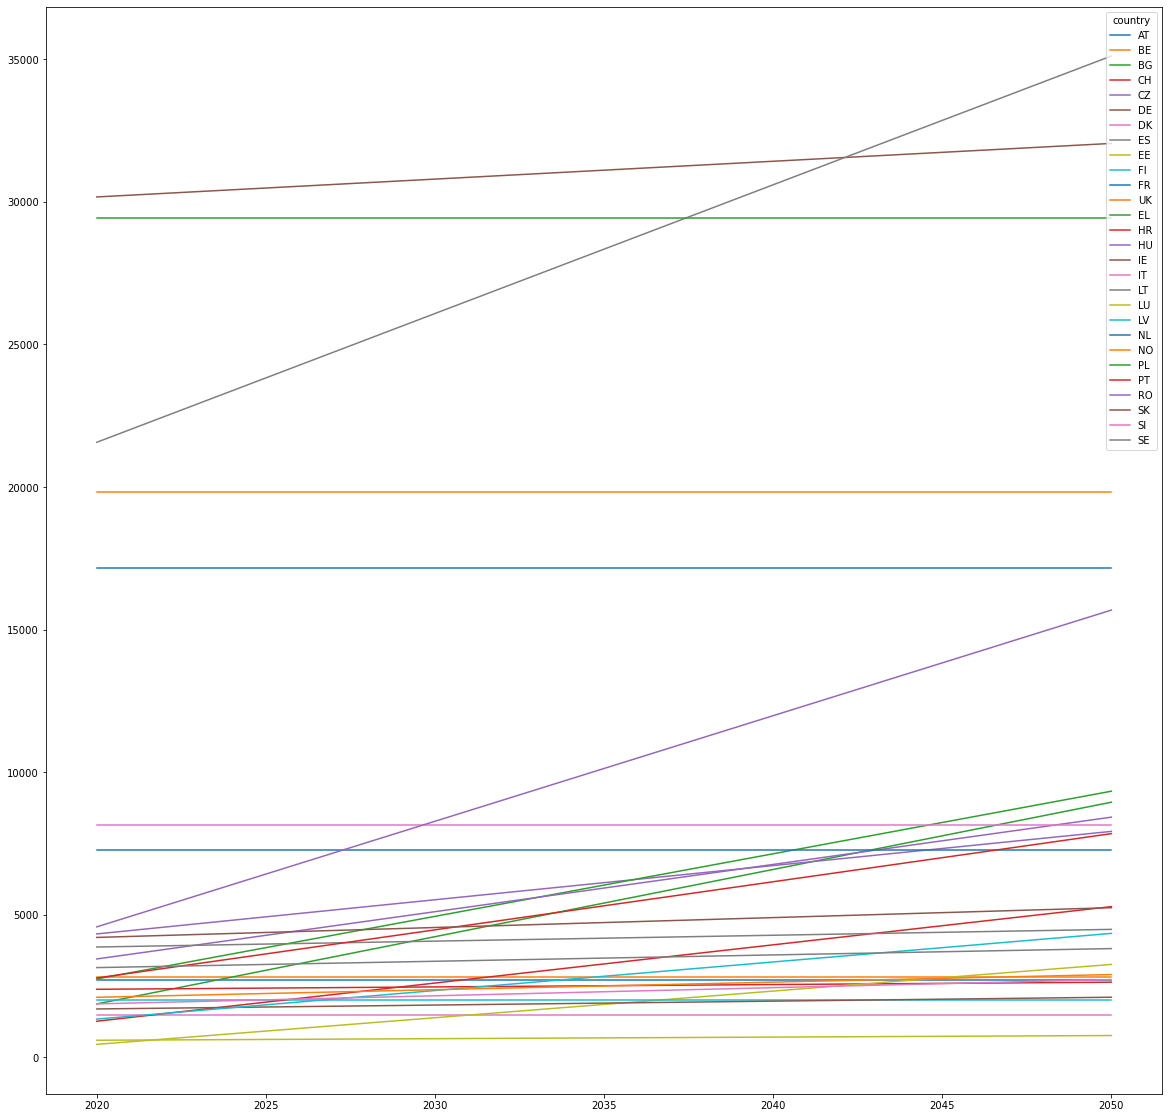

In [214]:
T_Demand = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Demand_prediction_Pop_Size_GDP')
T_Demand = T_Demand.set_index('country')
fig, ax = plt.subplots(1, 1, figsize = (20,20))
T_Demand.T.plot(ax=ax)

# 1. Scenario 100% BEV for distance class <50km, 50 - 149km, 150 -299km. 30% BEV and 70% CEV for 300 - 499km. 100% CEV >500km

In [215]:
Mio_Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_distance_class')
Mio_Vkm = Mio_Vkm.set_index(['country','distance_class'])
kWh_km = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Vehicle Fuel Efficiency/FE_By_Country_P.xlsx')
kWh_km = kWh_km.set_index(['country','distance_class','Powertrain'])
powertrain_share = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results.xlsm', sheet_name = '100%_BEV_CEV')
powertrain_share = powertrain_share.set_index(['Lifetime','distance_class','Powertrain'])
transport_share_region = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/transport_share_region.xlsx', sheet_name = 'regional_transport_share_2050')
transport_share_region = transport_share_region.set_index(['country','id'])

In [216]:
transport_share_region

2020      2021      2022      2023      2024      2025      2026      2027      2028      2029      2030      2031      2032      2033      2034      2035      2036      2037      2038      2039      2040      2041      2042      2043      2044      2045      2046      2047      2048      2049      2050
country id                                                                                                                                                                                                                                                                                                                         
BE      BE100  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605  0.026605
        BE211  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116  0.111116
...                 ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
CH      CH066  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341  0.012341
        CH070  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988  0.035988

[1811 rows x 31 columns]

In [217]:
transport_share_region = transport_share_region.droplevel(0)
transport_share_region

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BE100,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605,0.026605
BE211,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116,0.111116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH066,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341,0.012341
CH070,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988,0.035988


In [218]:
transport_share_region = transport_share_region.reindex(gdf.set_index('id').index)
transport_share_region

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930
CZ053,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949
UKH24,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889


In [219]:
transport_share_region = transport_share_region.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)
transport_share_region

,,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,CZ,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930,0.053930
CZ053,CZ,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528,0.049528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,UK,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949,0.014949
UKH24,UK,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889


In [220]:
Mio_Vkm

2020        2021        2022        2023        2024        2025        2026        2027        2028        2029        2030        2031        2032       2033        2034        2035        2036        2037        2038        2039        2040        2041        2042        2043        2044        2045        2046        2047        2048        2049        2050
country distance_class                                                                                                                                                                                                                                                                                                                                                                                   
AT      50km            559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.00000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000  559.000000
        50-149km        847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.00000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000  847.000000
...                            ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...        ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...
SE      300-499km       499.846052  499.692104  499.538156  499.384208  499.230261  499.076313  498.922365  498.768417  498.614469  498.460521  498.306573  498.152625  497.998677  497.84473  497.690782  497.536834  497.382886  497.228938  497.074990  496.921042  496.767094  496.613146  496.459198  496.305251  496.151303  495.997355  495.843407  495.689459  495.535511  495.381563  495.227615
        500km           554.829118  554.658236  554.487354  554.316471  554.145589  553.974707  553.803825  553.632943  553.462061  553.291178  553.120296  552.949414  552.778532  552.60765  552.436768  552.265885  552.095003  551.924121  551.753239  551.582357  551.411475  551.240592  551.069710  550.898828  550.727946  550.557064  550.386182  550.215300  550.044417  549.873535  549.702653

[140 rows x 31 columns]

In [222]:
Vkm = Mio_Vkm.multiply(1000000)
Vkm

2020          2021          2022          2023          2024          2025          2026          2027          2028          2029          2030          2031          2032          2033          2034          2035          2036          2037          2038          2039          2040          2041          2042          2043          2044          2045          2046          2047          2048          2049          2050
country distance_class                                                                                                                                                                                                                                                                                                                                                                                                                                                  
AT      50km            5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08  5.590000e+08
        50-149km        8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08  8.470000e+08
...                              ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...
SE      300-499km       4.998461e+08  4.996921e+08  4.995382e+08  4.993842e+08  4.992303e+08  4.990763e+08  4.989224e+08  4.987684e+08  4.986145e+08  4.984605e+08  4.983066e+08  4.981526e+08  4.979987e+08  4.978447e+08  4.976908e+08  4.975368e+08  4.973829e+08  4.972289e+08  4.970750e+08  4.969210e+08  4.967671e+08  4.966131e+08  4.964592e+08  4.963053e+08  4.961513e+08  4.959974e+08  4.958434e+08  4.956895e+08  4.955355e+08  4.953816e+08  4.952276e+08
        500km           5.548291e+08  5.546582e+08  5.544874e+08  5.543165e+08  5.541456e+08  5.539747e+08  5.538038e+08  5.536329e+08  5.534621e+08  5.532912e+08  5.531203e+08  5.529494e+08  5.527785e+08  5.526076e+08  5.524368e+08  5.522659e+08  5.520950e+08  5.519241e+08  5.517532e+08  5.515824e+08  5.514115e+08  5.512406e+08  5.510697e+08  5.508988e+08  5.507279e+08  5.505571e+08  5.503862e+08  5.502153e+08  5.500444e+08  5.498735e+08  5.497027e+08

[140 rows x 31 columns]

In [223]:
kWh_km

2020      2021      2022      2023      2024      2025      2026      2027      2028      2029      2030      2031      2032      2033      2034      2035      2036      2037      2038      2039      2040      2041      2042      2043      2044      2045      2046      2047      2048      2049      2050
country distance_class Powertrain                                                                                                                                                                                                                                                                                                                      
CH      50km           Diesel      3.171725  3.117709  3.063693  3.009677  2.955661  2.901645  2.847629  2.793613  2.739597  2.685581  2.631565  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347
                       Biofuel     3.171725  3.117709  3.063693  3.009677  2.955661  2.901645  2.847629  2.793613  2.739597  2.685581  2.631565  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347  1.773347
...                                     ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
BE      500km          FCEV        1.814906  1.805171  1.795436  1.785701  1.775967  1.766232  1.756497  1.746762  1.737027  1.727292  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557  1.717557
                       CEV         1.152801  1.137052  1.121303  1.105553  1.089804  1.074055  1.058306  1.042557  1.026808  1.011059  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310  0.995310

[2520 rows x 31 columns]

In [224]:
powertrain_share

2020      2021      2022      2023      2024      2025      2026      2027      2028      2029      2030      2031      2032      2033      2034      2035      2036      2037      2038      2039      2040      2041      2042      2043      2044      2045      2046      2047      2048      2049      2050
Lifetime distance_class Powertrain                                                                                                                                                                                                                                                                                                                      
8y       50km           Diesel      0.987724  0.984706  0.980699  0.975342  0.968134  0.958387  0.945173  0.927289  0.892773  0.843831  0.777645  0.694348  0.598104  0.495379  0.392454  0.294664  0.206843  0.133586  0.078416  0.041908  0.020786  0.009826  0.004524  0.002056  0.000929  0.000418  0.000188  0.000085  0.000038  0.000017  0.000008
                        Biofuel     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
...                                      ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
22y      500km          CEV         0.000045  0.000078  0.000144  0.000280  0.000563  0.001164  0.002450  0.005183  0.010843  0.021925  0.041597  0.071975  0.111981  0.157615  0.204478  0.249581  0.291492  0.329789  0.364558  0.396091  0.424735  0.450829  0.496255  0.541691  0.587127  0.632547  0.677923  0.723187  0.768179  0.812528  0.855431
                        Total       1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000

[760 rows x 31 columns]

In [225]:
pow_share = powertrain_share.drop(index = 'Total', level = 2)
pow_share

2020      2021      2022      2023      2024      2025      2026      2027      2028      2029      2030      2031      2032      2033      2034      2035      2036      2037      2038      2039      2040      2041      2042      2043      2044      2045      2046      2047      2048      2049      2050
Lifetime distance_class Powertrain                                                                                                                                                                                                                                                                                                                      
8y       50km           Diesel      0.987724  0.984706  0.980699  0.975342  0.968134  0.958387  0.945173  0.927289  0.892773  0.843831  0.777645  0.694348  0.598104  0.495379  0.392454  0.294664  0.206843  0.133586  0.078416  0.041908  0.020786  0.009826  0.004524  0.002056  0.000929  0.000418  0.000188  0.000085  0.000038  0.000017  0.000008
                        Biofuel     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
...                                      ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
22y      500km          FCEV        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
                        CEV         0.000045  0.000078  0.000144  0.000280  0.000563  0.001164  0.002450  0.005183  0.010843  0.021925  0.041597  0.071975  0.111981  0.157615  0.204478  0.249581  0.291492  0.329789  0.364558  0.396091  0.424735  0.450829  0.496255  0.541691  0.587127  0.632547  0.677923  0.723187  0.768179  0.812528  0.855431

[720 rows x 31 columns]

In [226]:
powertrain_share_8y = pow_share.loc['8y']
powertrain_share_8y

2020      2021      2022      2023      2024      2025      2026      2027      2028      2029      2030      2031      2032      2033      2034      2035      2036      2037      2038      2039      2040      2041      2042      2043      2044      2045      2046      2047      2048      2049      2050
distance_class Powertrain                                                                                                                                                                                                                                                                                                                      
50km           Diesel      0.987724  0.984706  0.980699  0.975342  0.968134  0.958387  0.945173  0.927289  0.892773  0.843831  0.777645  0.694348  0.598104  0.495379  0.392454  0.294664  0.206843  0.133586  0.078416  0.041908  0.020786  0.009826  0.004524  0.002056  0.000929  0.000418  0.000188  0.000085  0.000038  0.000017  0.000008
               Biofuel     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
...                             ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
500km          FCEV        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
               CEV         0.000045  0.000078  0.000144  0.000280  0.000563  0.001164  0.002450  0.005183  0.012193  0.027387  0.057142  0.107822  0.181618  0.274953  0.381252  0.493979  0.607221  0.714619  0.808629  0.882265  0.932959  0.963954  0.981311  0.990508  0.995232  0.997619  0.998814  0.999410  0.999707  0.999854  0.999928

[90 rows x 31 columns]

In [227]:
kWh_all_powertrains = Vkm.multiply(kWh_km)
kWh_all_powertrains

2020          2021          2022          2023          2024          2025          2026          2027          2028          2029          2030          2031          2032          2033          2034          2035          2036          2037          2038          2039          2040          2041          2042          2043          2044          2045          2046          2047          2048          2049          2050
country distance_class Powertrain                                                                                                                                                                                                                                                                                                                                                                                                                                                  
AT      150-299km      Diesel      3.179020e+09  3.104428e+09  3.029837e+09  2.955245e+09  2.880654e+09  2.806062e+09  2.731471e+09  2.656879e+09  2.582288e+09  2.507696e+09  2.433105e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09
                       Biofuel     3.179020e+09  3.104428e+09  3.029837e+09  2.955245e+09  2.880654e+09  2.806062e+09  2.731471e+09  2.656879e+09  2.582288e+09  2.507696e+09  2.433105e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09  1.633910e+09
...                                         ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...
UK      50km           FCEV        1.088080e+09  1.074948e+09  1.061816e+09  1.048684e+09  1.035552e+09  1.022420e+09  1.009288e+09  9.961560e+08  9.830240e+08  9.698920e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08  9.567600e+08
                       CEV         6.472200e+08  6.397160e+08  6.322120e+08  6.247080e+08  6.172040e+08  6.097000e+08  6.021960e+08  5.946920e+08  5.871880e+08  5.796840e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08  5.721800e+08

[2520 rows x 31 columns]

In [228]:
kWh_tot = kWh_all_powertrains.multiply(powertrain_share_8y)
gWh_tot = kWh_tot.multiply(0.000001)
gWh_tot

2020      2021      2022      2023      2024      2025       2026       2027       2028       2029        2030        2031        2032        2033        2034        2035        2036        2037        2038        2039        2040         2041         2042         2043         2044         2045         2046         2047         2048         2049         2050
distance_class Powertrain            country                                                                                                                                                                                                                                                                                                                                                                              
150-299km      BEV                   AT       0.727122  1.059301  1.597528  2.484859  3.968936  6.478357  10.747863  18.000925  33.825054  61.820882  107.564118  178.383127  271.135573  379.013724  494.287810  610.455997  721.603947  821.124493  901.831213  958.929514  993.653162  1012.234438  1021.372173  1025.660619  1027.626895  1028.518589  1028.920929  1029.102052  1029.183505  1029.220119  1029.236573
                                     BE       0.555706  0.810978  1.225237  1.909360  3.055682  4.997851   8.309282  13.947627  26.269519  48.128689   83.954104  139.228545  211.622096  295.821303  385.793059  476.462664  563.213960  640.890032  703.881860  748.447248  775.549156   790.051895   797.183923   800.531068   802.065752   802.761722   803.075749   803.217117   803.280691   803.309267   803.322110
...                                                ...       ...       ...       ...       ...       ...        ...        ...        ...        ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...
50km           Synthetic Methane HEV SK       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
                                     UK       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000

[2520 rows x 31 columns]

In [229]:
gWh_tot_region = gWh_tot.multiply(transport_share_region)
gWh_tot_region

2020  2021  2022  2023  2024  2025  2026  2027  2028  2029  2030  2031  2032  2033  2034  2035  2036  2037  2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  2048  2049  2050
country Powertrain            distance_class id                                                                                                                                                                                             
AL      NaN                   NaN            AL013   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
                                             AL015   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
...                                                  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
UK      Synthetic Methane HEV 50km           UKH23   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
                                             UKH24   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

[125143 rows x 31 columns]

In [230]:
gWh_tot_region_tot = gWh_tot_region.groupby('id').sum()
gWh_tot_region_tot.columns = gWh_tot_region_tot.columns.astype(str)
gWh_tot_region_tot

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN15,118.048397,115.894461,113.767644,111.616367,109.414644,107.131900,104.723552,102.122453,98.885262,94.955591,90.039926,65.355504,62.440061,59.062597,55.444182,51.788477,48.284235,45.129087,42.523860,40.602770,39.348613,38.609737,38.203510,37.988725,37.877278,37.819854,37.790279,37.775003,37.767076,37.762940,37.760768
UKN16,116.336816,114.214109,112.118129,109.998043,107.828243,105.578596,103.205167,100.641782,97.451527,93.578832,88.734438,64.407916,61.534744,58.206250,54.640297,51.037597,47.584163,44.474761,41.907308,40.014071,38.778098,38.049935,37.649598,37.437927,37.328096,37.271504,37.242359,37.227304,37.219492,37.215415,37.213276


In [231]:
gdf_dw

,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
id,,,,,,,,,,
CZ052,3,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122..."
CZ053,3,4,Pardubický kraj,CZ,CZ053,CZ053,Pardubický kraj,3,3,"POLYGON ((4812156.935 2965655.696, 4782782.205..."
...,...,...,...,...,...,...,...,...,...,...
UKH23,2,4,Hertfordshire,UK,UKH23,UKH23,Hertfordshire,3,1,"POLYGON ((3641428.795 3257056.214, 3631036.624..."
UKH24,3,4,Bedford,UK,UKH24,UKH24,Bedford,3,1,"POLYGON ((3622635.044 3279775.638, 3598326.240..."


<AxesSubplot:>

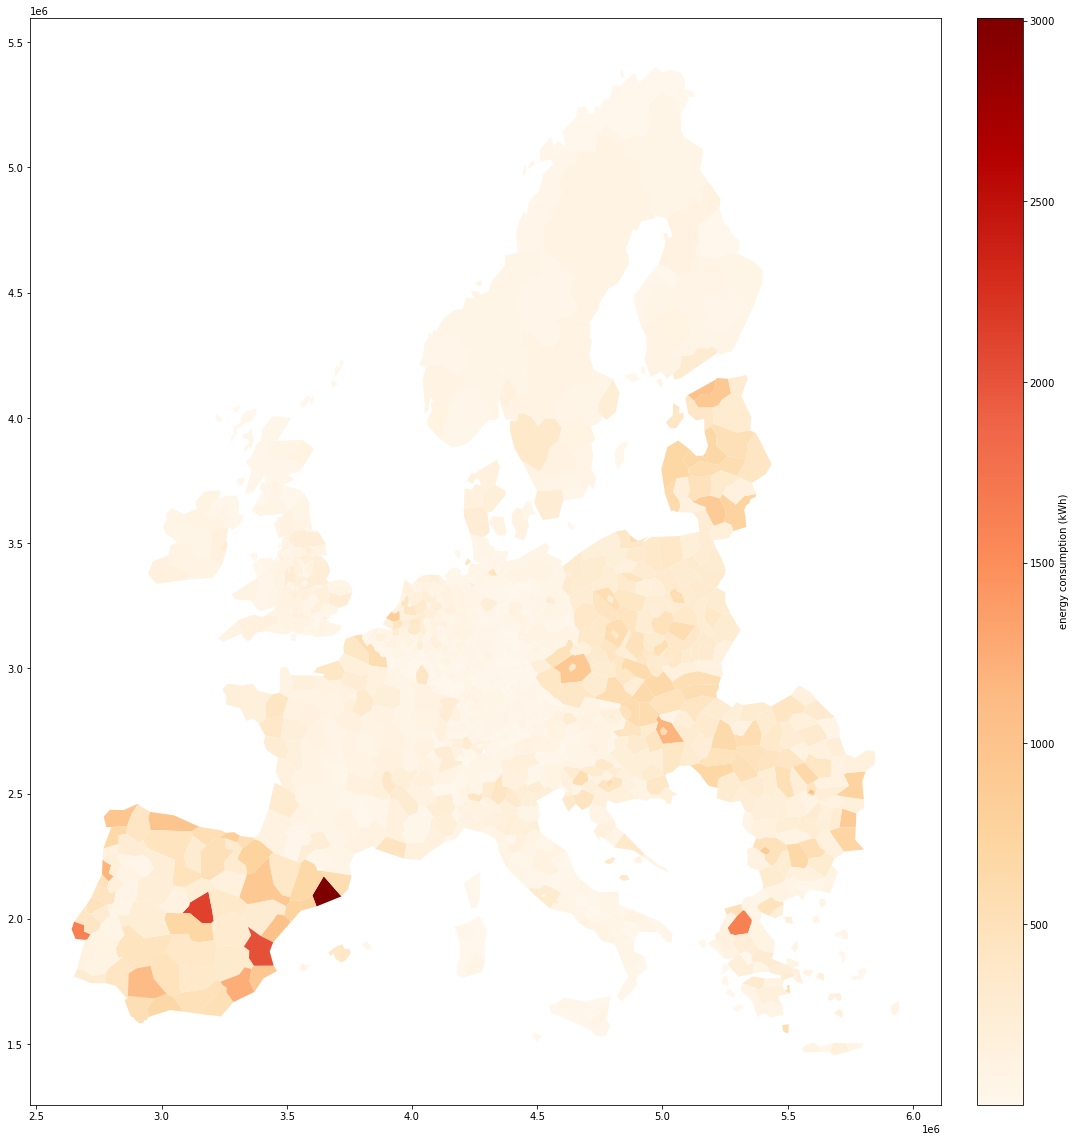

In [232]:
gdf_gWh_tot_region_tot = gdf_dw.join(gWh_tot_region_tot)
gdf_gWh_tot_region_tot = gdf_gWh_tot_region_tot.replace(0, np.nan)
gdf_gWh_tot_region_tot = gdf_gWh_tot_region_tot.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200'])

fig, ax = plt.subplots(1, 1, figsize = (20,20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_tot_region_tot.plot(column = '2050', 
         ax = ax, 
         legend=True,
         cax = cax,
         legend_kwds = {'label': 'energy consumption (kWh)'},
         cmap = 'OrRd'
         )


In [263]:
gdf_gWh_tot_region_tot

,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,3.0,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",530.662580,536.718131,542.445984,547.500923,551.705609,554.853737,556.650787,556.661049,551.829614,541.934131,524.974504,404.891161,392.964545,376.968510,358.327734,338.466634,318.807634,300.929810,286.521663,276.839874,272.004429,271.039062,272.630302,275.716839,279.619844,283.953276,288.510024,293.181977,297.913351,302.675455,307.453519
CZ053,3.0,4,Pardubický kraj,CZ,CZ053,CZ053,Pardubický kraj,3,3,"POLYGON ((4812156.935 2965655.696, 4782782.205...",487.345777,492.907027,498.167328,502.809644,506.671110,509.562264,511.212624,511.222048,506.784993,497.697256,482.122006,371.840798,360.887726,346.197411,329.078240,310.838357,292.784077,276.365581,263.133539,254.242052,249.801314,248.914748,250.376098,253.210689,256.795099,260.774804,264.959594,269.250186,273.595348,277.968732,282.356774
CZ063,3.0,4,Kraj Vysočina,CZ,CZ063,CZ063,Kraj Vysočina,3,3,"POLYGON ((4782782.205 2960974.984, 4775981.726...",494.233946,499.873799,505.208449,509.916380,513.832425,516.764442,518.438128,518.447686,513.947917,504.731733,488.936342,377.096414,365.988531,351.090582,333.729448,315.231762,296.922302,280.271746,266.852681,257.835522,253.332018,252.432921,253.914927,256.789581,260.424654,264.460607,268.704546,273.055781,277.462358,281.897556,286.347618
CZ064,3.0,4,Jihomoravský kraj,CZ,CZ064,CZ064,Jihomoravský kraj,3,2,"POLYGON ((4841157.679 2932184.124, 4851727.509...",994.108759,1005.452834,1016.183021,1025.652615,1033.529400,1039.426899,1042.793374,1042.812598,1033.761702,1015.224148,983.453087,758.496762,736.154217,706.188285,671.267867,634.061375,597.233483,563.742332,536.751046,518.613812,509.555403,507.746948,510.727874,516.509992,523.821626,531.939597,540.475912,549.228045,558.091492,567.012508,575.963423
CZ071,3.0,2,Olomoucký kraj,CZ,CZ071,CZ071,Olomoucký kraj,3,2,"POLYGON ((4849853.547 3042644.759, 4835135.745...",691.718600,699.612010,707.078265,713.667378,719.148185,723.251770,725.594223,725.607600,719.309825,706.411064,684.304194,527.775572,512.229230,491.378400,467.080151,441.191210,415.565706,392.261966,373.480949,360.860738,354.557735,353.299380,355.373561,359.396862,364.484427,370.133056,376.072776,382.162666,388.330011,394.537413,400.765619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH16,1.0,4,North and West Norfolk,UK,UKH16,UKH16,North and West Norfolk,3,3,"POLYGON ((3760200.001 3324800.736, 3715302.262...",193.107309,189.583831,186.104716,182.585589,178.983941,175.249756,171.310105,167.055145,161.759645,155.331365,147.290163,106.910604,102.141430,96.616468,90.697349,84.717232,78.984881,73.823590,69.561878,66.419297,64.367708,63.159031,62.494512,62.143159,61.960852,61.866915,61.818536,61.793547,61.780580,61.773813,61.770261
UKH17,2.0,4,Breckland and South Norfolk,UK,UKH17,UKH17,Breckland and South Norfolk,3,3,"POLYGON ((3754275.042 3301188.055, 3706277.604...",259.862297,255.120794,250.438989,245.703340,240.856643,235.831593,230.530049,224.804198,217.678105,209.027642,198.206688,143.868378,137.450555,130.015676,122.050385,114.003010,106.289052,99.343561,93.608624,89.379688,86.618889,84.992386,84.098150,83.625339,83.380010,83.253600,83.188497,83.154870,83.137420,83.128314,83.123535
UKH21,2.0,4,Luton,UK,UKH21,UKH21,Luton,3,1,"POLYGON ((3608276.298 3251322.689, 3605470.224...",54.484632,53.490493,52.508872,51.515961,50.499767,49.446178,48.334618,47.134094,45.639985,43.826266,41.557465,30.164497,28.818890,27.260039,25.589977,23.902706,22.285341,20.829098,19.626669,18.740000,18.161150,17.820126,17.632634

In [233]:
roads=gpd.read_file('C:/Users/seanp/Desktop/Roads_Europe')

<AxesSubplot:>

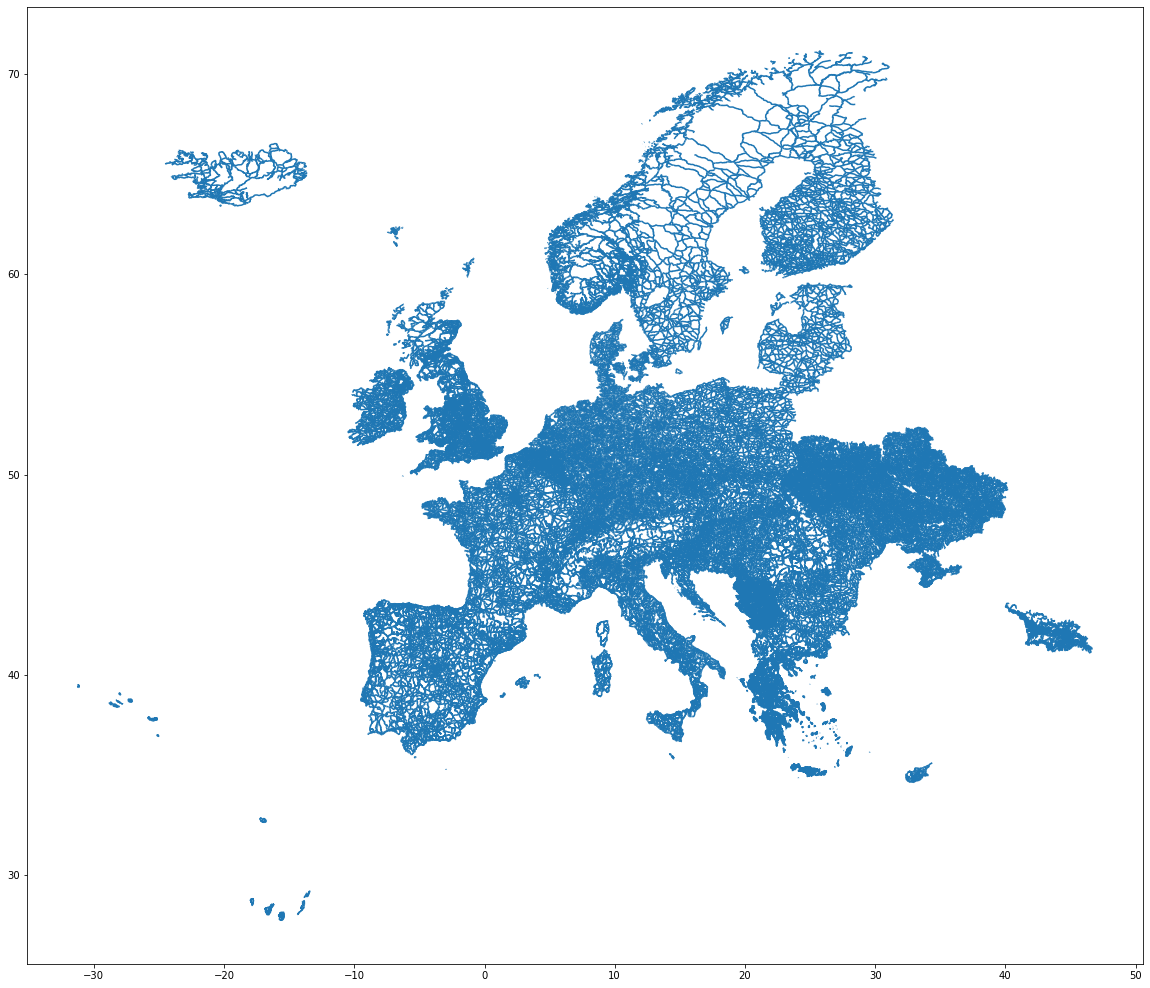

In [234]:
fig, ax = plt.subplots(1, 1, figsize = (20,20))
roads.plot(ax=ax)

In [235]:
roads

,FCsubtype,inspireId,beginLifes,F_CODE,ICC,COR,EXS,LLE,LTN,MED,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,RST,RSU,RTE,RTN,RTT,TEN,TOL,TUC,SHAPE_Leng,geometry
0,1,_EG.EGM.RoadL:07cad247-e48b-4509-989b-5b85513b...,2018-08-02,AP030,GB,999,28,1,-29999,2,N_P,N_A,N_P,N_A,N_A,N_A,1,1,N_A,N_A,984,0,1,7,0.081129,"LINESTRING (-2.18981 52.48982, -2.19998 52.491..."
1,1,_EG.EGM.RoadL:d6a4b288-909f-4882-a850-2cd1226e...,2018-08-02,AP030,ES,999,28,1,2,2,N_P,N_A,N_P,N_A,N_A,N_A,1,1,N_A,UNK,984,0,1,7,0.023452,"LINESTRING (-0.40707 39.33689, -0.40764 39.332..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414542,1,_EG.EGM.RoadL:31d416ac-2fa4-4fac-af57-0a68b3fd...,2014-01-20,AP030,UA,997,28,1,-29999,2,None,None,None,None,None,None,2,1,N_A,N_A,984,0,0,0,0.000152,"LINESTRING (24.99056 48.08232, 24.99053 48.08247)"
414543,1,_EG.EGM.RoadL:b7c25136-7b64-4d92-8159-e3126ab5...,2014-01-20,AP030,UA,997,28,1,-29999,2,None,None,None,None,None,None,2,1,N_A,N_A,984,0,0,0,0.009678,"LINESTRING (32.35967 47.16280, 32.35770 47.17228)"


In [347]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

In [237]:
roads_crs_3035 = roads.to_crs(epsg = 3035)


In [238]:
roads_crs_3035

,FCsubtype,inspireId,beginLifes,F_CODE,ICC,COR,EXS,LLE,LTN,MED,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,RST,RSU,RTE,RTN,RTT,TEN,TOL,TUC,SHAPE_Leng,geometry
0,1,_EG.EGM.RoadL:07cad247-e48b-4509-989b-5b85513b...,2018-08-02,AP030,GB,999,28,1,-29999,2,N_P,N_A,N_P,N_A,N_A,N_A,1,1,N_A,N_A,984,0,1,7,0.081129,"LINESTRING (3497461.493 3333737.769, 3496805.2..."
1,1,_EG.EGM.RoadL:d6a4b288-909f-4882-a850-2cd1226e...,2018-08-02,AP030,ES,999,28,1,2,2,N_P,N_A,N_P,N_A,N_A,N_A,1,1,N_A,UNK,984,0,1,7,0.023452,"LINESTRING (3421639.499 1866823.862, 3421536.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414542,1,_EG.EGM.RoadL:31d416ac-2fa4-4fac-af57-0a68b3fd...,2014-01-20,AP030,UA,997,28,1,-29999,2,None,None,None,None,None,None,2,1,N_A,N_A,984,0,0,0,0.000152,"LINESTRING (5429670.877 2887414.593, 5429665.3..."
414543,1,_EG.EGM.RoadL:b7c25136-7b64-4d92-8159-e3126ab5...,2014-01-20,AP030,UA,997,28,1,-29999,2,None,None,None,None,None,None,2,1,N_A,N_A,984,0,0,0,0.009678,"LINESTRING (5988291.831 2926830.538, 5987845.4..."


In [256]:
road_m = roads_crs_3035.length
road_m = road_m.to_frame(name = 'road_m')
road_m = roads_crs_3035.join(road_m)

In [262]:
roads_nuts = gpd.sjoin(gdf_gWh_tot_region_tot, road_m)
roads_nuts

,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,index_right,FCsubtype,inspireId,beginLifes,F_CODE,ICC,COR,EXS,LLE,LTN,MED,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,RST,RSU,RTE,RTN,RTT,TEN,TOL,TUC,SHAPE_Leng,road_m
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,3.0,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",530.662580,536.718131,542.445984,547.500923,551.705609,554.853737,556.650787,556.661049,551.829614,541.934131,524.974504,404.891161,392.964545,376.968510,358.327734,338.466634,318.807634,300.929810,286.521663,276.839874,272.004429,271.039062,272.630302,275.716839,279.619844,283.953276,288.510024,293.181977,297.913351,302.675455,307.453519,72145,1,_EG.EGM.RoadL:25027814-b07c-44f8-82f9-558f25dc...,2018-08-02,AP030,CZ,999,28,1,2,2,N_A,N_A,N_A,N_A,N_A,N_A,1,1,N_A,284,15,0,1,7,0.016434,1173.169026
CZ051,3.0,3,Liberecký kraj,CZ,CZ051,CZ051,Liberecký kraj,3,2,"POLYGON ((4710986.851 3088955.848, 4715726.276...",323.932493,327.628985,331.125439,334.211127,336.777795,338.699507,339.796480,339.802745,336.853491,330.812988,320.460320,247.157814,239.877447,230.112983,218.734089,206.610273,194.609824,183.696660,174.901491,168.991434,166.039732,165.450443,166.421784,168.305900,170.688412,173.333670,176.115247,178.967148,181.855322,184.762254,187.678929,72145,1,_EG.EGM.RoadL:25027814-b07c-44f8-82f9-558f25dc...,2018-08-02,AP030,CZ,999,28,1,2,2,N_A,N_A,N_A,N_A,N_A,N_A,1,1,N_A,284,15,0,1,7,0.016434,1173.169026
CZ052,3.0,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",530.662580,536.718131,542.445984,547.500923,551.705609,554.853737,556.650787,556.661049,551.829614,541.934131,524.974504,404.891161,392.964545,376.968510,358.327734,338.466634,318.807634,300.929810,286.521663,276.839874,272.004429,271.039062,272.630302,275.716839,279.619844,283.953276,288.510024,293.181977,297.913351,302.675455,307.453519,144624,1,_EG.EGM.RoadL:c52f4902-0dd7-49c1-903b-9d6b5748...,2018-08-02,AP030,CZ,999,28,1,2,2,N_A,N_A,N_A,N_A,N_A,N_A,1,1,N_A,284,15,0,1,7,0.035226,2674.898841
CZ052,3.0,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",530.662580,536.718131,542.445984,547.500923,551.705609,554.853737,556.650787,556.661049,551.829614,541.934131,524.974504,404.891161,392.964545,376.968510,358.327734,338.466634,318.807634,300.929810,286.521663,276.839874,272.004429,271.039062,272.630302,275.716839,279.619844,283.953276,288.510024,293.181977,297.913351,302.675455,307.453519,287504,1,_EG.EGM.RoadL:615998b3-abc0-4b19-adb6-4a0f2fa1...,2018-08-02,AP030,CZ,999,28,1,2,2,N_A,N_A,N_A,N_A,N_A,N_A,1,1,N_A,325,15,0,1,7,0.028772,2693.242777
CZ052,3.0,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",530.662580,536.718131,542.445984,547.500923,551.705609,554.853737,556.650787,556.661049,551.829614,541.934131,524.974504,404.891161,392.964545,376.968510,358.327734,338.466634,318.807634,300.929810,286.521663,276.839874,272.004429,271.039062,272.630302,275.716839,279.619844,283.953276,288.510024,293.181977,297.913351,302.675455,307.453519,216314,1,_EG.EGM.RoadL:fb571201-f2b2-453b-960c-48c444c5...,2018-08-02,AP030,CZ,999,28,1,2,2,N_A,N_A,N_A,N_A,N_A,N_A,1,1,N_A,283,15,0,1,7,0.028958,2650.489184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH24,3.0,4,Bedford,UK,UKH24,UKH24,Bedford,3,1,"POLYGON ((3622635.044 3279775.638, 3598326.240...",112.203261,110.155976,108.134468,106.0897

In [261]:
road_nuts_length = roads_nuts.groupby('id').sum()
road_nuts_length

,COAST_TYPE,MOUNT_TYPE,LEVL_CODE,URBN_TYPE,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,index_right,FCsubtype,COR,EXS,LLE,LTN,MED,RST,RSU,RTT,TEN,TOL,TUC,SHAPE_Leng,road_m
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL011,15.0,20,15,15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1881830,5,4985,140,5,10,10,5,5,75,0,5,0,0.341666,33057.841313
AL033,8.0,32,24,24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1513159,8,6995,224,8,16,16,8,8,6902,1,8,56,0.562769,53860.847011
AL034,4.0,16,12,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1312821,4,3990,112,4,8,8,4,4,1029,0,4,7,0.777588,76351.238012
AT111,108.0,144,108,108,1720.752327,1684.206416,1648.287707,1611.960569,1574.762635,1536.198225,1495.585316,1451.942137,1397.787128,1333.282953,1254.419633,910.617528,864.482499,811.725036,755.766018,699.728792,646.483218,598.979207,560.126265,531.753725,513.419639,502.740302,496.943710,493.921799,492.377278,491.593933,491.197074,490.995526,490.892727,490.840018,490.812835,4327401,36,22990,985,41,87,72,36,36,1503,0,62,281,2.102088,190367.703264
AT112,528.0,704,528,528,37931.995689,37126.383322,36334.596914,35533.807159,34713.821712,33863.713861,32968.449244,32006.385812,30812.601250,29390.681293,27652.230579,20073.510632,19056.517267,17893.539990,16659.988132,15424.712270,14250.975143,13203.804129,12347.335960,11721.896112,11317.742369,11082.328731,10954.549575,10887.935046,10853.887857,10836.619927,10827.871625,10823.428732,10821.162648,10820.000727,10819.401511,32143671,186,-224708,-323032,-327497,-327258,-327386,-327514,-327514,-307765,-327660,-327422,-326373,5.361559,479134.981873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN12,236.0,944,708,708,20282.565733,19912.485659,19547.065134,19177.442009,18799.151500,18406.940243,17993.148380,17546.238821,16990.038650,16314.859538,15470.271083,11229.100388,10728.181570,10147.880355,9526.179791,8898.072453,8295.988675,7753.884756,7306.265995,6976.192476,6760.708768,6633.758217,6563.962066,6527.058583,6507.910326,6498.043875,6492.962539,6490.337918,6488.975892,6488.265170,6487.892126,35593577,244,-95189,-255760,-261914,-261671,-261692,-261916,-261916,-258832,-262112,-261916,-260548,10.084880,805353.198130
UKN13,176.0,704,528,352,20461.900655,20088.548397,19719.896886,19347.005619,18965.370330,18569.691210,18152.240671,17701.379615,17140.261619,16459.112691,15607.056531,11328.386142,10823.038287,10237.606149,9610.408617,8976.747664,8369.340365,7822.443257,7370.866729,7037.874757,6820.485780,6692.412754,6621.999478,6584.769701,6565.452138,6555.498450,6550.372185,6547.724358,6546.350289,6545.633283,6545.256941,32241741,181,-68796,-159052,-163657,-163415,-163527,-163669,-163669,-161343,-163804,-163669,-162643,4.795204,376044.798268
UKN14,294.0,588,441,147,14210.213873,13950.931242,13694.913148,13435.950662,13170.915700,12896.127691,12606.220046,12293.109738,11903.429088,11430.390336,10838.661324,7867.245210,7516.295354,7109.729218,6674.158191,6234.098500,5812.271234,5432.466591,5118.859407,4887.605858,4736.635335,4647.692224,4598.792186,

In [242]:
road_nuts_length.columns = road_nuts_length.columns.astype(str)
road_nuts_length.columns

Index(['COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050', 'index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng', 'road_km'], dtype='object')

In [243]:
road_nuts_length_select = road_nuts_length.drop(columns=['COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE', 'index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng'])
road_nuts_length_select

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,road_km
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33057.841313
AL033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53860.847011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN15,12631.178520,12400.707309,12173.137880,11942.951240,11707.366895,11463.113260,11205.420079,10927.102508,10580.723074,10160.248267,9634.272033,6993.038922,6681.086524,6319.697914,5932.527429,5541.367060,5166.413132,4828.812284,4550.053051,4344.496338,4210.301620,4131.241846,4087.775567,4064.793540,4052.868764,4046.724330,4043.559874,4041.925365,4041.077149,4040.634539,4040.402222,374413.379853
UKN16,14774.775598,14505.191852,14239.002341,13969.751458,13694.186845,13408.481704,13107.056233,12781.506274,12376.343889,11884.511642,11269.273656,8179.805286,7814.912440,7392.193720,6939.317765,6481.774815,6043.188650,5648.294638,5322.228063,5081.786975,4924.818499,4832.341742,4781.498940,4754.616707,4740.668214,4733.481027,4729.779543,4727.867645,4726.875482,4726.357758,4726.086015,693503.315042


In [268]:
road_km_select = road_nuts_length_select['road_km']
road_km_select.to_frame(name = 'road_km')
road_km_select = road_km_select.div(1000)
road_km_select

id
AL011     33.057841
AL033     53.860847
AL034     76.351238
AT111    190.367703
AT112    479.134982
            ...    
UKN12    805.353198
UKN13    376.044798
UKN14    362.043966
UKN15    374.413380
UKN16    693.503315
Name: road_km, Length: 1421, dtype: float64

In [245]:
gWh_div_roadkm_perRegion = road_nuts_length_select[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_nuts_length_select.road_km, axis = 0)
gWh_div_roadkm_perRegion

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
AL033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN15,0.033736,0.033120,0.032513,0.031898,0.031269,0.030616,0.029928,0.029185,0.028259,0.027136,0.025732,0.018677,0.017844,0.016879,0.015845,0.014800,0.013799,0.012897,0.012152,0.011603,0.011245,0.011034,0.010918,0.010856,0.010825,0.010808,0.01080,0.010795,0.010793,0.010792,0.010791
UKN16,0.021305,0.020916,0.020532,0.020144,0.019746,0.019334,0.018900,0.018430,0.017846,0.017137,0.016250,0.011795,0.011269,0.010659,0.010006,0.009346,0.008714,0.008145,0.007674,0.007328,0.007101,0.006968,0.006895,0.006856,0.006836,0.006825,0.00682,0.006817,0.006816,0.006815,0.006815


In [246]:
gdf_gWh_div_roadkm_perRegion = gdf_dw.join(gWh_div_roadkm_perRegion)
gdf_gWh_div_roadkm_perRegion

,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZ052,3,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122...",0.168974,0.170903,0.172727,0.174336,0.175675,0.176677,0.177250,0.177253,0.175714,0.172564,0.167163,0.128926,0.125128,0.120035,0.114099,0.107775,0.101515,0.095823,0.091235,0.088152,0.086612,0.086305,0.086811,0.087794,0.089037,0.090417,0.091868,0.093355,0.094862,0.096378,0.097900
CZ053,3,4,Pardubický kraj,CZ,CZ053,CZ053,Pardubický kraj,3,3,"POLYGON ((4812156.935 2965655.696, 4782782.205...",0.168025,0.169942,0.171756,0.173357,0.174688,0.175685,0.176254,0.176257,0.174727,0.171594,0.166224,0.128202,0.124425,0.119360,0.113458,0.107170,0.100945,0.095284,0.090722,0.087657,0.086125,0.085820,0.086324,0.087301,0.088537,0.089909,0.091352,0.092831,0.094329,0.095837,0.097350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKH23,2,4,Hertfordshire,UK,UKH23,UKH23,Hertfordshire,3,1,"POLYGON ((3641428.795 3257056.214, 3631036.624...",0.407100,0.399672,0.392338,0.384919,0.377326,0.369454,0.361149,0.352178,0.341015,0.327463,0.310511,0.225384,0.215330,0.203683,0.191204,0.178597,0.166513,0.155632,0.146647,0.140022,0.135697,0.133149,0.131748,0.131008,0.130623,0.130425,0.130323,0.130270,0.130243,0.130229,0.130221
UKH24,3,4,Bedford,UK,UKH24,UKH24,Bedford,3,1,"POLYGON ((3622635.044 3279775.638, 3598326.240...",0.035794,0.035141,0.034496,0.033844,0.033176,0.032484,0.031754,0.030965,0.029983,0.028792,0.027301,0.019817,0.018933,0.017909,0.016812,0.015703,0.014641,0.013684,0.012894,0.012311,0.011931,0.011707,0.011584,0.011519,0.011485,0.011468,0.011459,0.011454,0.011452,0.011450,0.011450


<AxesSubplot:>

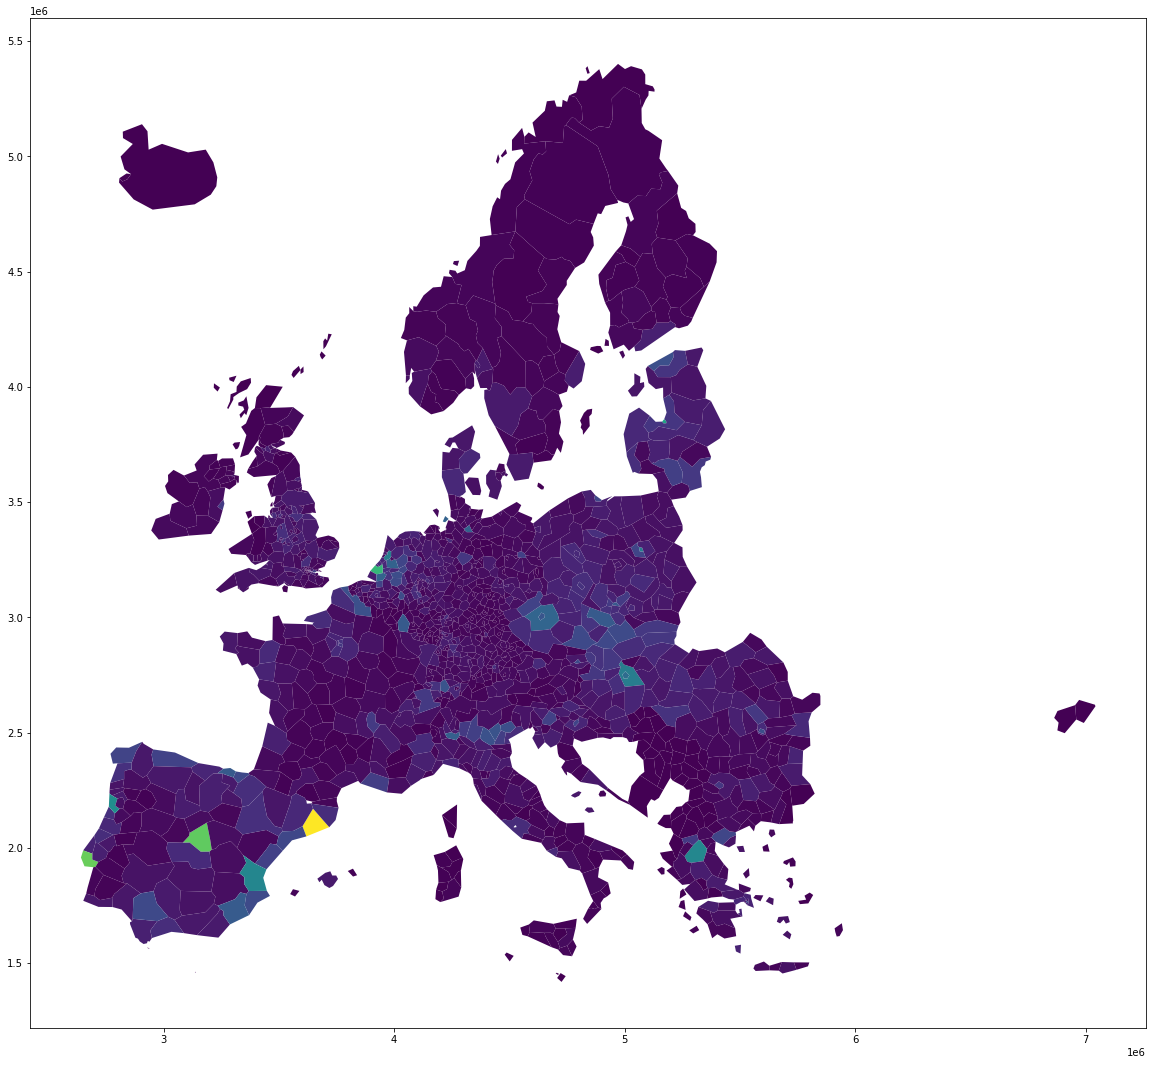

In [250]:
fig, ax = plt.subplots(1, 1, figsize = (20,20))
gdf_gWh_div_roadkm_perRegion.plot(column = '2050', 
                                  ax=ax,
                                 )

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AT111,0.009039,0.008847,0.008658,0.008468,0.008272,0.008070,0.007856,0.007627,0.007343,0.007004,0.006589,0.004783,0.004541,0.004264,0.003970,0.003676,0.003396,0.003146,0.002942,0.002793,0.002697,0.002641,0.002610,0.002595,0.002586,0.002582,0.002580,0.002579,0.002579,0.002578,0.002578
AT112,0.079168,0.077486,0.075834,0.074162,0.072451,0.070677,0.068808,0.066800,0.064309,0.061341,0.057713,0.041895,0.039773,0.037346,0.034771,0.032193,0.029743,0.027558,0.025770,0.024465,0.023621,0.023130,0.022863,0.022724,0.022653,0.022617,0.022599,0.022590,0.022585,0.022582,0.022581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN12,0.025185,0.024725,0.024271,0.023812,0.023343,0.022856,0.022342,0.021787,0.021096,0.020258,0.019209,0.013943,0.013321,0.012601,0.011829,0.011049,0.010301,0.009628,0.009072,0.008662,0.008395,0.008237,0.008150,0.008105,0.008081,0.008069,0.008062,0.008059,0.008057,0.008056,0.008056
UKN13,0.054413,0.053421,0.052440,0.051449,0.050434,0.049382,0.048271,0.047073,0.045580,0.043769,0.041503,0.030125,0.028781,0.027224,0.025557,0.023871,0.022256,0.020802,0.019601,0.018716,0.018137,0.017797,0.017610,0.017511,0.017459,0.017433,0.017419,0.017412,0.017408,0.017407,0.017406
UKN14,0.039250,0.038534,0.037827,0.037111,0.036379,0.035620,0.034820,0.033955,0.032878,0.031572,0.029937,0.021730,0.020761,0.019638,0.018435,0.017219,0.016054,0.015005,0.014139,0.013500,0.013083,0.012837,0.012702,0.012631,0.012594,0.012575,0.012565,0.012560,0.012557,0.012556,0.012555


# Complete Model

Code for all models

In [307]:
# Load gdf of NUTS 3 regions
gdf_dw = gpd.read_file('C:/Users/seanp/python/NUTS_RG_60M_2016_3035_LEVL_3.geojson')
gdf_dw = gdf_dw.set_index('id')

# Load Transport Demand Prediction (Unit Mio_Vkm)
Mio_Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_distance_class')
Mio_Vkm = Mio_Vkm.set_index(['country','distance_class'])

# Load Fuel Efficiency for each country and fuel type (Unit kWh/km)
kWh_km = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Vehicle Fuel Efficiency/FE_By_Country_P.xlsx')
kWh_km = kWh_km.set_index(['country','distance_class','Powertrain'])

# Load the transport share of each region compared to it's country
transport_share_region = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/transport_share_region.xlsx', sheet_name = 'regional_transport_share_2050')
transport_share_region = transport_share_region.set_index(['country','id'])

In [271]:
# reindex transport_share_region df with the index of gdf_df and create a multiindex with country code and NUTS 3 code
transport_share_region = transport_share_region.droplevel(0)
transport_share_region = transport_share_region.reindex(gdf_dw.set_index('id').index)
transport_share_region = transport_share_region.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)

In [272]:
# Adjust units from Mio_Vkm to Vkm
Vkm = Mio_Vkm.multiply(1000000)

In [273]:
# Multiply kWh/km of each powertrain technology by total Vkm to get the kWh of the Vehicle fleet if 100% of vehicles used one powertrain technology
kWh_all_powertrains = Vkm.multiply(kWh_km)

In [274]:
# Load gdf of Roads in Europe and transform the coordinate reference system
roads=gpd.read_file('C:/Users/seanp/Desktop/Roads_Europe')
roads_crs_3035 = roads.to_crs(epsg = 3035)

# Calculate lengthe of each road in meters and add a column with these values to road gdf
road_m = roads_crs_3035.length
road_m = road_m.to_frame(name = 'road_m')
road_m = roads_crs_3035.join(road_m)

Code for individual Scenarios

In [275]:
# Load results of the Scenarios produced by the VSM
powertrain_share = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results.xlsm', sheet_name = '100%_BEV_CEV')
powertrain_share = powertrain_share.set_index(['Lifetime','distance_class','Powertrain'])

In [276]:
# delete 'Total' from index in powertrain_share df
pow_share = powertrain_share.drop(index = 'Total', level = 2)

In [277]:
# select average life time of vehicles for this scenario (8y, 10y, 12y, 14y, 16y, 18y, 20y, 22y)
powertrain_share_8y = pow_share.loc['8y']

In [278]:
# multiply kWh if 100% of powertrains were using each technology, by the actual share of powertrains using each technology to get the total kWh demand of the vehicle fleet
kWh_tot = kWh_all_powertrains.multiply(powertrain_share_8y)

In [279]:
# multiply by konstand to transform kWh into gWh
gWh_tot = kWh_tot.multiply(0.000001)

In [280]:
# devide the total gWh demand of the vehicle fleet per country up into the NUTS 3 regions of each country
gWh_tot_region = gWh_tot.multiply(transport_share_region)

In [281]:
# Sum up the gWh of each distance class and powertrain technology for each NUTS 3 region
gWh_tot_region_tot = gWh_tot_region.groupby('id').sum()

In [311]:
# join gdf of NUTS 3 regions with gWh per region so it can assign the road_m to the correct NUTS 3 region
gdf_gWh_tot_region_tot = gdf_dw.join(gWh_tot_region_tot)

In [312]:
# combine gdf with total gWh per region with gdf with total road_m and sum up the road_m
roads_nuts = gpd.sjoin(gdf_gWh_tot_region_tot, road_m)
road_nuts_length = roads_nuts.groupby('id').sum()

In [366]:
# delete unnecessary columns in gdf (very important because the energy demand of fleet is also summed up so NUTS energy demands are mulitplied), div by 1000 --> m to km, change column name from m to km
road_nuts_length.columns = road_nuts_length.columns.astype(str)
road_nuts_length_select = road_nuts_length.drop(columns=['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050', 'COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE', 'index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng'])
road_km_select = road_nuts_length_select.div(1000)
road_km_select = road_km_select.rename(columns = {'road_m': 'road_km'})

In [365]:
# devide gWh of each year 2020 - 2050 by road_m to norm the NUTS 3 regions for their size difference
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot.columns = gdf_gWh_tot_region_tot.columns.astype(str)
gWh_div_roadkm_perRegion = gdf_gWh_tot_region_tot[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)

In [371]:
#join gdf of NUTS 3 regions with gWh per road_m
gdf_gWh_div_roadkm_perRegion = gdf_dw.join(gWh_div_roadkm_perRegion)

<AxesSubplot:>

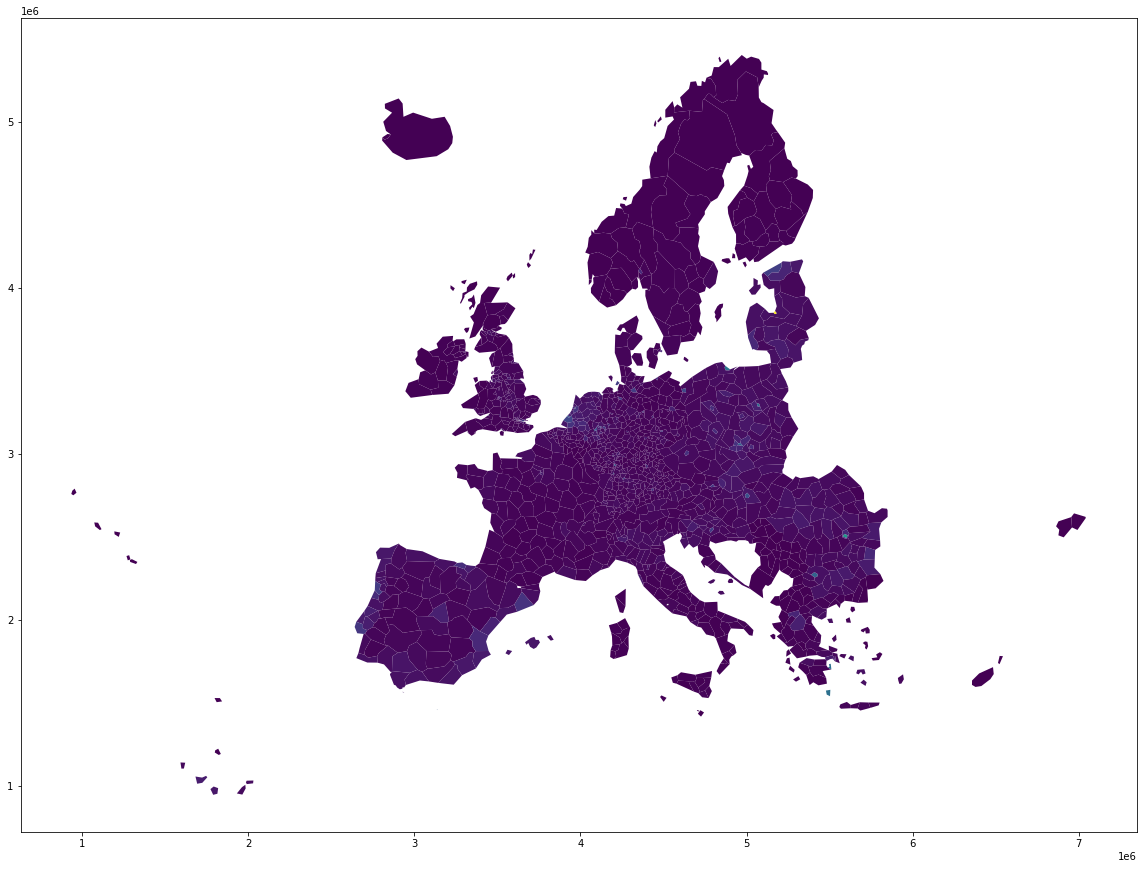

In [369]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize = (20,20))
gdf_gWh_div_roadkm_perRegion.plot(column = '2050', 
                                  ax=ax,
                                 )

# Devide Energy demand by km of road for each NUTS region to get a value that isn't dependent on region size anymore 

# Multiple Linear Regression For Transport Demand 

In [248]:
Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Vkm_1999-2019_P')
Vkm = Vkm.set_index('country')
GDP = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'GDP_1999-2019_P')
GDP = GDP.set_index('country')
GDPc = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'GDPc_1999-2019_P')
GDPc = GDPc.set_index('country')
Pop = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Pop_1999-2019_P')
Pop = Pop.set_index('country')
FuelPrice = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Fuel_Price_1999-2019_P')
FuelPrice = FuelPrice.set_index('country')
Size = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Country_Size_P')
Size = Size.set_index('country')

XLRDError: No sheet named <'Vkm_1999-2019_P'>

In [ ]:
GDP.columns = GDP.columns.astype(str)
Vkm.columns = Vkm.columns.astype(str)
print(GDP.columns)
print(Vkm.columns)

In [ ]:
Vkm.align(GDP)

In [ ]:
Vkm

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
FuelPrice.T.plot(ax=ax)

In [ ]:
x = GDP
y = Vkm

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

predictions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
predictions.T.plot(ax=ax)

# Test area

In [ ]:
toe_mio_Vkm_country.columns = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
toe_mio_Vkm_country

In [ ]:
gdf_MWh_region = gdf_dw.join(MWh_region)
gdf_MWh_region = gdf_MWh_region.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200'])
fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_MWh_region.plot(column = '2019', 
         ax = ax, 
         legend=True,
         cax = cax,
         legend_kwds = {'label': 'energy consumption (mwh)'},
         cmap = 'viridis',
         missing_kwds= dict(color = "lightgrey")
         )

In [ ]:
maxValuesObj = MWh_region_filledna.max()
pd.set_option("display.max_rows", 50, "display.max_columns", 50)
MWh_region_filledna.loc[(slice(None), 'FR'), :]

gdf_MWh_region_select = gdf_MWh_region.cx[0.22:,1:]

In [ ]:
toe_mio_Vkm_country.columns = toe_mio_Vkm_country.columns.int.replace(' ', '')
print(toe_mio_Vkm_country.columns)

In [ ]:
MWh_region.columns = MWh_region.columns.str.replace(' ', '')
print(MWh_region.columns)

In [ ]:
MWh_region.columns = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
MWh_region

In [ ]:
#loading international transport dataset
df_unloading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_ugtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
df_loading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_lgtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
#filtering dataset to proper data
df_unloading_int_EC = df_unloading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_unloading_int_EC = df_unloading_int_EC.droplevel(0)
df_loading_int_EC = df_loading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_loading_int_EC = df_loading_int_EC.droplevel(0)
#average of loaning and unloading
df_average_transport_total_int_EC = pd.concat((df_loading_int_EC, df_unloading_int_EC))
df_average_transport_total_int_EC = df_average_transport_total_int_EC.groupby(df_average_transport_total_int_EC.index).mean()
#multiplay international transport with share of total national tranport for each region
international_transport_region = share_total_national_transport_region.multiply(df_average_transport_total_int_EC)
#sum of national and international transport
df_average_transport_total = df_average_transport_total.droplevel(1)
international_transport_region = international_transport_region.droplevel(1)
total_national_international_transport_region = pd.concat((international_transport_region, df_average_transport_total))
total_national_international_transport_region = total_national_international_transport_region.groupby('id').sum()
total_national_international_transport_region

In [ ]:
international_transport_region

In [ ]:
df_average_transport_total

In [ ]:
#devide total mio vehicle TKM by total transport per region to get km driven by trucks in that region
df_total_transport_mio_Tkm_region_EC = share_total_national_transport_region.multiply(df_total_transport_mio_Tkm_country_EC)
km_driven_region = df_total_transport_mio_Tkm_region_EC.divide(total_national_international_transport_region)
km_driven_region

In [ ]:
df_total_transport_mio_Tkm_region_EC

In [ ]:
df_total_transport_mio_Tkm_region_EC = share_total_national_transport_region.multiply(df_total_transport_mio_Tkm_country_EC)

In [ ]:
test = km_driven_region.iloc[1343:1522]

In [ ]:
print(gdf.iloc[0:5])

In [ ]:
#trying to use different dataset with total transport amount
df_unloading_test = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_ru.tsv.gz',['subsector', 'unit', 'region'])

In [ ]:
idx = pd.IndexSlice
df_unloading_test = df_unloading_test.loc[idx[:,'THS_T'], :]
df_unloading_test = df_unloading_test.droplevel('unit')
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.reindex(gdf.set_index('id').index)




df_unloading_test = df_unloading_test.loc[idx[:,['THS_T']]]
df_unloading_test = df_unloading_test.droplevel(1)
df_unloading_total = df_unloading.loc['THS_T']
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.droplevel(0)

In [ ]:
#sorting gdf according to id so it might aligne with eurostats data
gdf_sort = gdf.sort_values(by=['id'])

In [ ]:
#selecting 2019 column
df_at_2019 = df_average_transport.iloc[:, 0]

In [ ]:
print(df_at_2019.iloc[100:105])

In [ ]:
gdf_sort['TRANSPORT_AMOUNT_2019'] = df_at_2019

In [ ]:
print(gdf_sort.iloc[100:150])

In [ ]:
gdf_sort.head()

In [ ]:
#alinge dataframes and delet all lines with no shared id